# imports

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install tensorflow==2.9.1
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 26 kB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.0 MB 86.1 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.


In [5]:
import sys
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
# !pip install pybboxes
import shutil
import os 
import pandas as pd
# import pybboxes as pbx
import mediapipe as mp
from pathlib import Path

from tensorflow.keras.applications import Xception,InceptionV3,ResNet50V2
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
# GPU config if using gpu then uncomment following lines


#Dataset

In [6]:
!mv /content/drive/MyDrive/yami.zip /content/
!unzip yami.zip 
!mv /content/yami.zip /content/drive/MyDrive/ 

mv: cannot stat '/content/drive/MyDrive/yami.zip': No such file or directory
unzip:  cannot find or open yami.zip, yami.zip.zip or yami.zip.ZIP.
mv: cannot stat '/content/yami.zip': No such file or directory


In [7]:
%cd content
%mv * ../
%cd ..

/content
mv: cannot move 'drive' to '../drive': Device or resource busy
/


#DAiSEE

In [ ]:
!rm -rf Yami

In [ ]:
from pathlib import Path
import subprocess
import pandas as pd
from progressbar import ProgressBar


def get_frames(subdirectory, video, odir):
    """
    Run the ffmpeg command to extract the frames. If subdirectory is
    FinalTest than it will extract frames at default frame rate else it
    will extract frames at 0.7fps.
    Args:
        subdirectory: Specify it as either Train, Test, Validation or
            FinalTest.
        video: Path to input video.
        odir: Path to store output video.
    """
    if subdirectory == "FinalTest":
        subprocess.run(f"ffmpeg -i {video} "
                       f"{odir}/{video.parts[-1][:-4]}_%d.jpeg "
                       "-loglevel quiet", shell=True, check=True)
    else:
        subprocess.run(f"ffmpeg -i {video} -vf fps=0.7 "
                       f"{odir}/{video.parts[-1][:-4]}_%1d.jpeg "
                       "-loglevel quiet", shell=True, check=True)


def main(data_dir, label_dir, out_dir):
    """
    Extract frames from videos avaialble in the original DAiSEE dataset.
    Extracted frames will be stored as jpeg images.
    Args:
        data_dir: Path to directory which contains videos.
            This directory will contain Test, Train and Validation
            subdirectory, which has same structure as downloaded from
            the DAiSEE website.
        label_dir: Path to directory which contains three csv files
            namely TrainLabels.csv, TestLabels.csv, ValidationLabels.csv
        out_dir: Path to directory which will be used to store extracted
            frames. If the directory is not already present it will be
            created.
    """
    data_dir = Path(data_dir)
    label_dir = Path(label_dir)
    out_dir = Path(out_dir)

    subdirectories = ["Train", "Test", "Validation", "FinalTest"]
    for subdirectory in subdirectories:
        if subdirectory == "FinalTest":
            sdir = data_dir / "Test"
            label_path = str(label_dir) + "/TestLabels.csv"
        else:
            sdir = data_dir / subdirectory
            label_path = str(label_dir) + f"/{subdirectory}Labels.csv"
        odir = out_dir / subdirectory
        odir.mkdir(parents=True, exist_ok=True)
        label = pd.read_csv(label_path)
        print(f"Extracting frames for {subdirectory}")
        with ProgressBar(max_value=len(list(sdir.glob("*/*/*")))) as bar:
            for i, video in enumerate(sdir.glob("*/*/*")):
                if label['ClipID'].str.contains(video.parts[-1]).any():
                    get_frames(subdirectory, video, odir)
                bar.update(i)



main('/content/DAiSEE/DataSet', '/content/DAiSEE/Labels', '/content/Data')

Extracting frames for Train


100% (5482 of 5482) |####################| Elapsed Time: 0:21:24 Time:  0:21:24
N/A% (0 of 1866) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Extracting frames for Test


100% (1866 of 1866) |####################| Elapsed Time: 0:06:53 Time:  0:06:53


Extracting frames for Validation


100% (1720 of 1720) |####################| Elapsed Time: 0:05:07 Time:  0:05:07
N/A% (0 of 1866) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Extracting frames for FinalTest


100% (1866 of 1866) |####################| Elapsed Time: 0:21:53 Time:  0:21:53


In [ ]:
!zip -r data.zip /content/Data

In [ ]:
!mv data.zip /content/drive/MyDrive/

In [ ]:
!mv Numpy /content/drive/MyDrive

#save labels

In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np
from progressbar import ProgressBar


def save_filepath_label(usage, frame_dir, label_dir, out_dir):
    """
    Save filepaths of all the frames and their respective output label
    as numpy array.
    Namely this numpy array's would be x_train, y_train, etc.
    This numpy array would be directly used in input pipeline for
    training and testing of model.
    Args:
        usage: Specify it as Train, Test, Validation or FinalTest.
        frame_dir: Path to directory which contains extracted frames.
        label_dir: Path to directory which contains labels csv files.
        out_dir: Path to directory which will be used to store numpy
            arrays of filepath and labels.
    """
    frame_dir = frame_dir / usage

    if usage == "FinalTest":
        label_path = str(label_dir) + "/TestLabels.csv"
    else:
        label_path = str(label_dir) + f"/{usage}Labels.csv"

    labeldf = pd.read_csv(label_path)
    nrows = len(list(frame_dir.glob("*.jpeg")))
    ncols = len(labeldf.columns) - 1
    filepath = np.empty((nrows,), dtype=np.object)
    label = np.empty((nrows, ncols), dtype=np.float32)
    print(f"Getting filepath and labels for {usage}")
    with ProgressBar(max_value=nrows) as bar:
        for i, frame in enumerate(frame_dir.glob("*.jpeg")):
            filepath[i] = str(frame)
            framename = frame.parts[-1]
            frameid = framename[:framename.find("_")]
            video = frameid + ".avi"
            if labeldf['ClipID'].str.contains(video).any():
                lidx = labeldf.index[labeldf['ClipID'].str.contains(video)]
            else:
                video = frameid + ".mp4"
                lidx = labeldf.index[labeldf['ClipID'].str.contains(video)]
            label[i] = labeldf.iloc[lidx, 1:]
            bar.update(i)

    np.random.seed(100)
    indices = np.random.permutation(nrows)
    filepath = filepath[indices]
    label = label[indices]
    np.save(f"{str(out_dir)}/x_{usage.lower()}", filepath, allow_pickle=True)
    np.save(f"{str(out_dir)}/y_{usage.lower()}", label)
    return filepath, label


def main(frame_dir, label_dir, out_dir):
    """
    Call the savefile_path_label function for Train, Test, Validatin and
    FinalTest.
    """
    frame_dir = Path(frame_dir)
    label_dir = Path(label_dir)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    save_filepath_label("Train", frame_dir, label_dir, out_dir)
    save_filepath_label("Test", frame_dir, label_dir, out_dir)
    save_filepath_label("Validation", frame_dir, label_dir, out_dir)
    save_filepath_label("FinalTest", frame_dir, label_dir, out_dir)



main('/content/Data', '/content/DAiSEE/Labels', '/content/Numpy')

#Pipeline

##HOG

In [ ]:
# from skimage.feature import hog
# from skimage import exposure


# fd, hog_image = hog(imgs[1], orientations=10, pixels_per_cell=(8, 8), 
#                     cells_per_block=(2, 2), visualize=True, multichannel=True)


In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

# ax1.imshow(imgs[1], cmap=plt.cm.gray) 
# ax1.set_title('Input image') 

# # Rescale histogram for better display 
# hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 20)) 
# hog_image_rescaled = cv2.merge([hog_image_rescaled,hog_image_rescaled,hog_image_rescaled])
# print(hog_image_rescaled.shape)
# a
# ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
# ax2.set_title('Histogram of Oriented Gradients')

# plt.show()

##Preprocessing

In [ ]:
import typing
def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> typing.Union[None, typing.Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


In [ ]:
def cut_image(img,xmin,ymin,w,h):
        yolo_bbox1 = (xmin,ymin,w,h)
        W, H = 640, 640
        rect_start_point = _normalized_to_pixel_coordinates(
        xmin, ymin, W,H)
        target_size = (W,H,3)
        rect_end_point = _normalized_to_pixel_coordinates(
        xmin + w,
        ymin + h, W, H)  
        image_arr = tf.keras.preprocessing.image.img_to_array(img)
        if not(rect_start_point is None or rect_end_point is None):
        
          image_arr = image_arr[rect_start_point[1]:rect_end_point[1],rect_start_point[0]:rect_end_point[0],]

        image_arr = tf.image.resize(image_arr,(target_size[0],target_size[1]))
        return image_arr

In [ ]:
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure


In [ ]:
weight_dir = '/content/drive/MyDrive/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
numpy_dir = '/content/drive/MyDrive/Numpy'
out_dir_train = 'Train2.0'

In [ ]:
def to_nump(image):
  image = image.numpy()
  with mp_face_detection.FaceDetection(
          min_detection_confidence=0.5, model_selection=1) as face_detection:

          # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
      results = face_detection.process(np.uint8(image*255))

          # Draw face detections of each face.
  if not results.detections:
          # print('gg')
          return image
  for detection in results.detections:
          xmin = detection.location_data.relative_bounding_box.xmin
          ymin = detection.location_data.relative_bounding_box.ymin
          width = detection.location_data.relative_bounding_box.width
          height = detection.location_data.relative_bounding_box.height
  image = cut_image(image,xmin,ymin,width,height)
  return image

In [ ]:
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure
sess = tf.compat.v1.Session()
class_names = np.array(
    ['Boredom', 'Engagement', 'Confusion', 'Frustration']
)
autotune = tf.data.experimental.AUTOTUNE
img_width = 640
img_height = 640
batch_size = 16
shuffle_buffer_size = 2000
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

tf.executing_eagerly()

def show_batch(image, label):
    """
    Show batch of images and labels using matplotlib.
    Args:
        image: Batch of images.
        label: Batch of labels for the given batch of images.
    """
    # plt.imshow(annotated_image)
    image = image.numpy()
    plt.figure(figsize=(15, 15))
    for i in range(batch_size):
        # with mp_face_detection.FaceDetection(
        #   min_detection_confidence=0.5, model_selection=1) as face_detection:

        #   # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
        #     results = face_detection.process(np.uint8(image[i]*255))

        #   # Draw face detections of each face.
        # if not results.detections:
        #   continue
        # for detection in results.detections:
        #   xmin = detection.location_data.relative_bounding_box.xmin
        #   ymin = detection.location_data.relative_bounding_box.ymin
        #   width = detection.location_data.relative_bounding_box.width
        #   height = detection.location_data.relative_bounding_box.height
        # image[i] = cut_image(image[i],xmin,ymin,width,height)
        plt.subplot(6, 6, i + 1)
        imgtitle = [label["y1"][i].numpy().item(),
                    label["y2"][i].numpy().item(),
                    label["y3"][i].numpy().item(),
                    label["y4"][i].numpy().item()]

        plt.imshow(np.uint8(image[i] * 255))
        plt.title(imgtitle, fontsize=8)
        plt.axis('off')
    plt.show()


def parse_function(filepath, label):
    """
    Read the images from given file path and do final preprocessing
    on the images and labels.
    Args:
        filepath: Path where the image is stored.
        label: Output label for the given image.
    Returns:
        Two tf.Tensor objects which contains transformed image and label.
    """
    image = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(contents=image, channels=3)
    image = tf.image.convert_image_dtype(image=image, dtype=tf.float32)
    image = tf.image.resize(images=image,
                            size=[img_width, img_height],
                            method=tf.image.ResizeMethod.BILINEAR,
                            antialias=True)
    y = tf.py_function(func=to_nump, inp=[image], Tout=tf.float32)
    print(type(y))
    return y, label


def get_dataset(usage, numpy_dir):
    """
    Create tf.data.Dataset object for the input pipeline from filepath
    and labels numpy arrays.
    This input pipeline will be used to train and test the model.
    Args:
        usage: Specify it as either Train, Test, or Validation or
            FinalTest.
        numpy_dir: Path to directory which contains numpy arrays of
            filepath and labels.
    Returns:
        tf.data.Dataset object.
    """
    numpy_dir = Path(numpy_dir)
    x = np.load(numpy_dir / f'x_{usage.lower()}.npy', allow_pickle=True)
    y = np.load(numpy_dir / f'y_{usage.lower()}.npy')
    dataset = tf.data.Dataset.from_tensor_slices(
        (x, {"y1": y[:, :1], "y2": y[:, 1:2],
             "y3": y[:, 2:3], "y4": y[:, :3:4]})
    ) 
    dataset = dataset.map(map_func=parse_function, num_parallel_calls=autotune)
    if usage == 'Train':
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size,
                                  reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(autotune)
    return dataset



# ds = get_dataset('test',numpy_dir)
# image_batch, label_batch = next(iter(ds))
# show_batch(image_batch, label_batch)

#Train Model

##Xception

In [ ]:

# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)



finetune_at = 116
base_learning_rate = 0.0001
old_epoch = 0
epochs = 10


def get_model(weight_dir, out_dir, fullyconnected=False, finetune=False):
    """
    Creates custom model on top of Xception for user engagement
    recognition.
    Returns:
        model for the training.
    """
    weights = Path(weight_dir)
    if finetune:
        if fullyconnected:
            base_model = load_model(str(out_dir) + "/Xception_on_DAiSEE_fc.h5")
        else:
            base_model = load_model(str(out_dir) + "/Xception_on_DAiSEE.h5")

        base_model.trainable = True
        for layer in base_model.layers[:finetune_at]:
            layer.trainable = False
        return base_model
    else:
        xception = weight_dir
        weights = weights / xception
        base_model = Xception(weights="imagenet",
                              include_top=False,
                              input_shape=(img_width, img_height, 3))

        base_model.trainable = False
        x = GlobalAveragePooling2D()(base_model.output)
        if fullyconnected:
            x = Dense(128, activation="relu", name="fc1")(x)
            x = Dense(64, activation="relu", name="fc2")(x)
        boredom = Dense(4, name="y1")(x)
        engagement = Dense(4, name="y2")(x)
        confusion = Dense(4, name="y3")(x)
        frustration = Dense(4, name="y4")(x)
        model = Model(inputs=base_model.input,
                      outputs=[boredom, engagement, confusion, frustration])
    return model


def main(weight_dir, numpy_dir, out_dir, fullyconnected=False, finetune=False):
    """
    Creates trained model for user engagement recognition.
    Args:
        weight_dir: Directory which contains pretrained weights for
            Xception with include_top=False.
        numpy_dir: Directory which contains filepath and labels array.
        out_dir: Directory to store models and logs.
        fullyconnected: Boolean indicating wheater to add two fully
            connected layers on top of Xception before the
            classification head or not, default to False.
        finetune: Boolean indicating wheater to finetune the model or
            not, default to False.
    """
    global old_epoch
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    log_dir = out_dir / "logs"
    log_dir.mkdir(parents=True, exist_ok=True)

    train_ds = get_dataset("Train", numpy_dir)
    validation_ds = get_dataset("Validation", numpy_dir)
    model = get_model(weight_dir, out_dir, fullyconnected, finetune)

    if finetune:
        lr = base_learning_rate / 10
        finetune_epochs = 10
        if fullyconnected:
            model_path = str(out_dir) + "/Xception_on_DAiSEE_finetune_fc.h5"
        else:
            model_path = str(out_dir) + "/Xception_on_DAiSEE_finetune.h5"
    else:
        lr = base_learning_rate
        finetune_epochs = 0
        if fullyconnected:
            model_path = str(out_dir) + "/Xception_on_DAiSEE_fc.h5"
        else:
            model_path = str(out_dir) + "/Xception_on_DAiSEE.h5"

    model.compile(optimizer=RMSprop(learning_rate=lr),
                  loss={"y1": SparseCategoricalCrossentropy(from_logits=True),
                        "y2": SparseCategoricalCrossentropy(from_logits=True),
                        "y3": SparseCategoricalCrossentropy(from_logits=True),
                        "y4": SparseCategoricalCrossentropy(from_logits=True)},
                  metrics={"y1": "sparse_categorical_accuracy",
                           "y2": "sparse_categorical_accuracy",
                           "y3": "sparse_categorical_accuracy",
                           "y4": "sparse_categorical_accuracy"})
    print(model.summary())

    callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=1e-2,
                      patience=2, verbose=1),
        TensorBoard(log_dir=str(log_dir))
    ]

    total_epochs = epochs + finetune_epochs
    history = model.fit(train_ds,
                        epochs=total_epochs,
                        initial_epoch=old_epoch,
                        callbacks=callbacks,
                        validation_data=validation_ds)
    if finetune:
        old_epoch = 0
    else:
        old_epoch = history.epoch[-1]
    print(history.history)
    model.save(model_path)


out_dir_train = '/content/drive/MyDrive/Presentation_Scoring_Models/Xception'

main(weight_dir, numpy_dir, out_dir_train)
main(weight_dir, numpy_dir, out_dir_train, finetune=True)
main(weight_dir, numpy_dir, out_dir_train, fullyconnected=True)
main(weight_dir, numpy_dir, out_dir_train,
      fullyconnected=True, finetune=True)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 319, 319, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 319, 319, 32  128        ['block1_conv1[0][0]']      

In [ ]:
# !zip -r train2.zip /content/Train2.0

  adding: content/Train2.0/ (stored 0%)
  adding: content/Train2.0/Xception_on_DAiSEE_fc.h5 (deflated 8%)
  adding: content/Train2.0/logs/ (stored 0%)
  adding: content/Train2.0/logs/train/ (stored 0%)
  adding: content/Train2.0/logs/train/events.out.tfevents.1670235521.ec198593ec26.114.2.v2 (deflated 93%)
  adding: content/Train2.0/logs/train/events.out.tfevents.1670231301.ec198593ec26.114.0.v2 (deflated 93%)
  adding: content/Train2.0/logs/train/events.out.tfevents.1670242964.ec198593ec26.114.6.v2 (deflated 93%)
  adding: content/Train2.0/logs/train/events.out.tfevents.1670238673.ec198593ec26.114.4.v2 (deflated 93%)
  adding: content/Train2.0/logs/validation/ (stored 0%)
  adding: content/Train2.0/logs/validation/events.out.tfevents.1670236170.ec198593ec26.114.3.v2 (deflated 78%)
  adding: content/Train2.0/logs/validation/events.out.tfevents.1670231864.ec198593ec26.114.1.v2 (deflated 79%)
  adding: content/Train2.0/logs/validation/events.out.tfevents.1670239244.ec198593ec26.114.5.v2 

In [ ]:
# !mv train2.zip /content/drive/MyDrive

In [ ]:
# !mv /content/drive/MyDrive/train2.zip .

In [ ]:
# !mv content/train2.zip .

In [ ]:
# %cd content 
# !mv * ..
# %cd ..

/content/content
/content


##Inception

In [ ]:

# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)



finetune_at = 116
base_learning_rate = 0.0001
old_epoch = 0
epochs = 10


def get_model(weight_dir, out_dir, fullyconnected=False, finetune=False):
    """
    Creates custom model on top of Inception for user engagement
    recognition.
    Returns:
        model for the training.
    """
    weights = Path(weight_dir)
    if finetune:
        if fullyconnected:
            base_model = load_model(str(out_dir) + "/Inception_on_DAiSEE_fc.h5")
        else:
            base_model = load_model(str(out_dir) + "/Inception_on_DAiSEE.h5")

        base_model.trainable = True
        for layer in base_model.layers[:finetune_at]:
            layer.trainable = False
        return base_model
    else:
        # Inception = weight_dir
        # weights = weights / Inception
        base_model = InceptionV3(weights="imagenet",
                              include_top=False,
                              input_shape=(img_width, img_height, 3))

        base_model.trainable = False
        x = GlobalAveragePooling2D()(base_model.output)
        if fullyconnected:
            x = Dense(128, activation="relu", name="fc1")(x)
            x = Dense(64, activation="relu", name="fc2")(x)
        boredom = Dense(4, name="y1")(x)
        engagement = Dense(4, name="y2")(x)
        confusion = Dense(4, name="y3")(x)
        frustration = Dense(4, name="y4")(x)
        model = Model(inputs=base_model.input,
                      outputs=[boredom, engagement, confusion, frustration])
    return model


def main(weight_dir, numpy_dir, out_dir, fullyconnected=False, finetune=False):
    """
    Creates trained model for user engagement recognition.
    Args:
        weight_dir: Directory which contains pretrained weights for
            Inception with include_top=False.
        numpy_dir: Directory which contains filepath and labels array.
        out_dir: Directory to store models and logs.
        fullyconnected: Boolean indicating wheater to add two fully
            connected layers on top of Inception before the
            classification head or not, default to False.
        finetune: Boolean indicating wheater to finetune the model or
            not, default to False.
    """
    global old_epoch
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    log_dir = out_dir / "logs"
    log_dir.mkdir(parents=True, exist_ok=True)

    train_ds = get_dataset("Train", numpy_dir)
    validation_ds = get_dataset("Validation", numpy_dir)
    model = get_model(weight_dir, out_dir, fullyconnected, finetune)

    if finetune:
        lr = base_learning_rate / 10
        finetune_epochs = 10
        if fullyconnected:
            model_path = str(out_dir) + "/Inception_on_DAiSEE_finetune_fc.h5"
        else:
            model_path = str(out_dir) + "/Inception_on_DAiSEE_finetune.h5"
    else:
        lr = base_learning_rate
        finetune_epochs = 0
        if fullyconnected:
            model_path = str(out_dir) + "/Inception_on_DAiSEE_fc.h5"
        else:
            model_path = str(out_dir) + "/Inception_on_DAiSEE.h5"

    model.compile(optimizer=RMSprop(learning_rate=lr),
                  loss={"y1": SparseCategoricalCrossentropy(from_logits=True),
                        "y2": SparseCategoricalCrossentropy(from_logits=True),
                        "y3": SparseCategoricalCrossentropy(from_logits=True),
                        "y4": SparseCategoricalCrossentropy(from_logits=True)},
                  metrics={"y1": "sparse_categorical_accuracy",
                           "y2": "sparse_categorical_accuracy",
                           "y3": "sparse_categorical_accuracy",
                           "y4": "sparse_categorical_accuracy"})
    print(model.summary())

    callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=1e-2,
                      patience=2, verbose=1),
        TensorBoard(log_dir=str(log_dir))
    ]

    total_epochs = epochs + finetune_epochs
    history = model.fit(train_ds,
                        epochs=total_epochs,
                        initial_epoch=old_epoch,
                        callbacks=callbacks,
                        validation_data=validation_ds)
    if finetune:
        old_epoch = 0
    else:
        old_epoch = history.epoch[-1]
    print(history.history)
    model.save(model_path)


out_dir_train = 'content/drive/MyDrive/Presentation_Scoring_Models/Inception'
main(weight_dir, numpy_dir, out_dir_train)
main(weight_dir, numpy_dir, out_dir_train, finetune=True)
main(weight_dir, numpy_dir, out_dir_train, fullyconnected=True)
main(weight_dir, numpy_dir, out_dir_train,
      fullyconnected=True, finetune=True)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
87910968/87910968 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 319, 319, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_12 (Bat

##ResNet

In [ ]:

# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)



finetune_at = 116
base_learning_rate = 0.0001
old_epoch = 0
epochs = 10


def get_model(weight_dir, out_dir, fullyconnected=False, finetune=False):
    """
    Creates custom model on top of ResNet for user engagement
    recognition.
    Returns:
        model for the training.
    """
    weights = Path(weight_dir)
    if finetune:
        if fullyconnected:
            base_model = load_model(str(out_dir) + "/ResNet_on_DAiSEE_fc.h5")
        else:
            base_model = load_model(str(out_dir) + "/ResNet_on_DAiSEE.h5")

        base_model.trainable = True
        for layer in base_model.layers[:finetune_at]:
            layer.trainable = False
        return base_model
    else:
        # ResNet = weight_dir
        # weights = weights / ResNet
        base_model = ResNet50V2(weights="imagenet",
                              include_top=False,
                              input_shape=(img_width, img_height, 3))

        base_model.trainable = False
        x = GlobalAveragePooling2D()(base_model.output)
        if fullyconnected:
            x = Dense(128, activation="relu", name="fc1")(x)
            x = Dense(64, activation="relu", name="fc2")(x)
        boredom = Dense(4, name="y1")(x)
        engagement = Dense(4, name="y2")(x)
        confusion = Dense(4, name="y3")(x)
        frustration = Dense(4, name="y4")(x)
        model = Model(inputs=base_model.input,
                      outputs=[boredom, engagement, confusion, frustration])
    return model


def main(weight_dir, numpy_dir, out_dir, fullyconnected=False, finetune=False):
    """
    Creates trained model for user engagement recognition.
    Args:
        weight_dir: Directory which contains pretrained weights for
            ResNet with include_top=False.
        numpy_dir: Directory which contains filepath and labels array.
        out_dir: Directory to store models and logs.
        fullyconnected: Boolean indicating wheater to add two fully
            connected layers on top of ResNet before the
            classification head or not, default to False.
        finetune: Boolean indicating wheater to finetune the model or
            not, default to False.
    """
    global old_epoch
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    log_dir = out_dir / "logs"
    log_dir.mkdir(parents=True, exist_ok=True)

    train_ds = get_dataset("Train", numpy_dir)
    validation_ds = get_dataset("Validation", numpy_dir)
    model = get_model(weight_dir, out_dir, fullyconnected, finetune)

    if finetune:
        lr = base_learning_rate / 10
        finetune_epochs = 10
        if fullyconnected:
            model_path = str(out_dir) + "/ResNet_on_DAiSEE_finetune_fc.h5"
        else:
            model_path = str(out_dir) + "/ResNet_on_DAiSEE_finetune.h5"
    else:
        lr = base_learning_rate
        finetune_epochs = 0
        if fullyconnected:
            model_path = str(out_dir) + "/ResNet_on_DAiSEE_fc.h5"
        else:
            model_path = str(out_dir) + "/ResNet_on_DAiSEE.h5"

    model.compile(optimizer=RMSprop(learning_rate=lr),
                  loss={"y1": SparseCategoricalCrossentropy(from_logits=True),
                        "y2": SparseCategoricalCrossentropy(from_logits=True),
                        "y3": SparseCategoricalCrossentropy(from_logits=True),
                        "y4": SparseCategoricalCrossentropy(from_logits=True)},
                  metrics={"y1": "sparse_categorical_accuracy",
                           "y2": "sparse_categorical_accuracy",
                           "y3": "sparse_categorical_accuracy",
                           "y4": "sparse_categorical_accuracy"})
    print(model.summary())

    callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=1e-2,
                      patience=2, verbose=1),
        TensorBoard(log_dir=str(log_dir))
    ]

    total_epochs = epochs + finetune_epochs
    history = model.fit(train_ds,
                        epochs=total_epochs,
                        initial_epoch=old_epoch,
                        callbacks=callbacks,
                        validation_data=validation_ds)
    if finetune:
        old_epoch = 0
    else:
        old_epoch = history.epoch[-1]
    print(history.history)
    model.save(model_path)


out_dir_train = 'content/drive/MyDrive/Presentation_Scoring_Models/ResNet'
main(weight_dir, numpy_dir, out_dir_train)
main(weight_dir, numpy_dir, out_dir_train, finetune=True)
main(weight_dir, numpy_dir, out_dir_train, fullyconnected=True)
main(weight_dir, numpy_dir, out_dir_train,
      fullyconnected=True, finetune=True)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
94668760/94668760 [==============================] - 0s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 646, 646, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 320, 320, 64  9472        ['conv1_pad[0][0]']              
                            

##MobileNet

In [ ]:
from tensorflow.keras.applications import EfficientNetB2,MobileNetV2

# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)



finetune_at = 116
base_learning_rate = 0.0001
old_epoch = 0
epochs = 10


def get_model(weight_dir, out_dir, fullyconnected=False, finetune=False):
    """
    Creates custom model on top of MobileNet for user engagement
    recognition.
    Returns:
        model for the training.
    """
    weights = Path(weight_dir)
    if finetune:
        if fullyconnected:
            base_model = load_model(str(out_dir) + "/MobileNet_on_DAiSEE_fc.h5")
        else:
            base_model = load_model(str(out_dir) + "/MobileNet_on_DAiSEE.h5")

        base_model.trainable = True
        for layer in base_model.layers[:finetune_at]:
            layer.trainable = False
        return base_model
    else:
        # MobileNet = weight_dir
        # weights = weights / MobileNet
        base_model = MobileNetV2(weights="imagenet",
                              include_top=False,
                              input_shape=(img_width, img_height, 3))

        base_model.trainable = False
        x = GlobalAveragePooling2D()(base_model.output)
        if fullyconnected:
            x = Dense(128, activation="relu", name="fc1")(x)
            x = Dense(64, activation="relu", name="fc2")(x)
        boredom = Dense(4, name="y1")(x)
        engagement = Dense(4, name="y2")(x)
        confusion = Dense(4, name="y3")(x)
        frustration = Dense(4, name="y4")(x)
        model = Model(inputs=base_model.input,
                      outputs=[boredom, engagement, confusion, frustration])
    return model


def main(weight_dir, numpy_dir, out_dir, fullyconnected=False, finetune=False):
    """
    Creates trained model for user engagement recognition.
    Args:
        weight_dir: Directory which contains pretrained weights for
            MobileNet with include_top=False.
        numpy_dir: Directory which contains filepath and labels array.
        out_dir: Directory to store models and logs.
        fullyconnected: Boolean indicating wheater to add two fully
            connected layers on top of MobileNet before the
            classification head or not, default to False.
        finetune: Boolean indicating wheater to finetune the model or
            not, default to False.
    """
    global old_epoch
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    log_dir = out_dir / "logs"
    log_dir.mkdir(parents=True, exist_ok=True)

    train_ds = get_dataset("Train", numpy_dir)
    validation_ds = get_dataset("Validation", numpy_dir)
    model = get_model(weight_dir, out_dir, fullyconnected, finetune)

    if finetune:
        lr = base_learning_rate / 10
        finetune_epochs = 10
        if fullyconnected:
            model_path = str(out_dir) + "/MobileNet_on_DAiSEE_finetune_fc.h5"
        else:
            model_path = str(out_dir) + "/MobileNet_on_DAiSEE_finetune.h5"
    else:
        lr = base_learning_rate
        finetune_epochs = 0
        if fullyconnected:
            model_path = str(out_dir) + "/MobileNet_on_DAiSEE_fc.h5"
        else:
            model_path = str(out_dir) + "/MobileNet_on_DAiSEE.h5"

    model.compile(optimizer=RMSprop(learning_rate=lr),
                  loss={"y1": SparseCategoricalCrossentropy(from_logits=True),
                        "y2": SparseCategoricalCrossentropy(from_logits=True),
                        "y3": SparseCategoricalCrossentropy(from_logits=True),
                        "y4": SparseCategoricalCrossentropy(from_logits=True)},
                  metrics={"y1": "sparse_categorical_accuracy",
                           "y2": "sparse_categorical_accuracy",
                           "y3": "sparse_categorical_accuracy",
                           "y4": "sparse_categorical_accuracy"})
    print(model.summary())

    callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=1e-2,
                      patience=2, verbose=1),
        TensorBoard(log_dir=str(log_dir))
    ]

    total_epochs = epochs + finetune_epochs
    history = model.fit(train_ds,
                        epochs=total_epochs,
                        initial_epoch=old_epoch,
                        callbacks=callbacks,
                        validation_data=validation_ds)
    if finetune:
        old_epoch = 0
    else:
        old_epoch = history.epoch[-1]
    print(history.history)
    model.save(model_path)


out_dir_train = 'content/drive/MyDrive/Presentation_Scoring_Models/MobileNet'
main(weight_dir, numpy_dir, out_dir_train)
main(weight_dir, numpy_dir, out_dir_train, finetune=True)
main(weight_dir, numpy_dir, out_dir_train, fullyconnected=True)
main(weight_dir, numpy_dir, out_dir_train,
      fullyconnected=True, finetune=True)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
9406464/9406464 [==============================] - 0s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 320, 320, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 320, 320, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 320, 320, 32  128         ['Conv1[0][0]']             

In [ ]:
!mv /content/content /content/drive/MyDrive

##EfficientNet

In [ ]:
from tensorflow.keras.applications import EfficientNetB2,MobileNetV2

# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)



finetune_at = 116
base_learning_rate = 0.0001
old_epoch = 0
epochs = 10


def get_model(weight_dir, out_dir, fullyconnected=False, finetune=False):
    """
    Creates custom model on top of EfficientNetB2 for user engagement
    recognition.
    Returns:
        model for the training.
    """
    weights = Path(weight_dir)
    if finetune:
        if fullyconnected:
            base_model = load_model(str(out_dir) + "/EfficientNetB2_on_DAiSEE_fc.h5")
        else:
            base_model = load_model(str(out_dir) + "/EfficientNetB2_on_DAiSEE.h5")

        base_model.trainable = True
        for layer in base_model.layers[:finetune_at]:
            layer.trainable = False
        return base_model
    else:
        # EfficientNetB2 = weight_dir
        # weights = weights / EfficientNetB2
        base_model = EfficientNetB2(weights="imagenet",
                              include_top=False,
                              input_shape=(img_width, img_height, 3))

        base_model.trainable = False
        x = GlobalAveragePooling2D()(base_model.output)
        if fullyconnected:
            x = Dense(128, activation="relu", name="fc1")(x)
            x = Dense(64, activation="relu", name="fc2")(x)
        boredom = Dense(4, name="y1")(x)
        engagement = Dense(4, name="y2")(x)
        confusion = Dense(4, name="y3")(x)
        frustration = Dense(4, name="y4")(x)
        model = Model(inputs=base_model.input,
                      outputs=[boredom, engagement, confusion, frustration])
    return model


def main(weight_dir, numpy_dir, out_dir, fullyconnected=False, finetune=False):
    """
    Creates trained model for user engagement recognition.
    Args:
        weight_dir: Directory which contains pretrained weights for
            EfficientNetB2 with include_top=False.
        numpy_dir: Directory which contains filepath and labels array.
        out_dir: Directory to store models and logs.
        fullyconnected: Boolean indicating wheater to add two fully
            connected layers on top of EfficientNetB2 before the
            classification head or not, default to False.
        finetune: Boolean indicating wheater to finetune the model or
            not, default to False.
    """
    global old_epoch
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    log_dir = out_dir / "logs"
    log_dir.mkdir(parents=True, exist_ok=True)

    train_ds = get_dataset("Train", numpy_dir)
    validation_ds = get_dataset("Validation", numpy_dir)
    model = get_model(weight_dir, out_dir, fullyconnected, finetune)

    if finetune:
        lr = base_learning_rate / 10
        finetune_epochs = 10
        if fullyconnected:
            model_path = str(out_dir) + "/EfficientNetB2_on_DAiSEE_finetune_fc.h5"
        else:
            model_path = str(out_dir) + "/EfficientNetB2_on_DAiSEE_finetune.h5"
    else:
        lr = base_learning_rate
        finetune_epochs = 0
        if fullyconnected:
            model_path = str(out_dir) + "/EfficientNetB2_on_DAiSEE_fc.h5"
        else:
            model_path = str(out_dir) + "/EfficientNetB2_on_DAiSEE.h5"

    model.compile(optimizer=RMSprop(learning_rate=lr),
                  loss={"y1": SparseCategoricalCrossentropy(from_logits=True),
                        "y2": SparseCategoricalCrossentropy(from_logits=True),
                        "y3": SparseCategoricalCrossentropy(from_logits=True),
                        "y4": SparseCategoricalCrossentropy(from_logits=True)},
                  metrics={"y1": "sparse_categorical_accuracy",
                           "y2": "sparse_categorical_accuracy",
                           "y3": "sparse_categorical_accuracy",
                           "y4": "sparse_categorical_accuracy"})
    print(model.summary())

    callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=1e-2,
                      patience=2, verbose=1),
        TensorBoard(log_dir=str(log_dir))
    ]

    total_epochs = epochs + finetune_epochs
    history = model.fit(train_ds,
                        epochs=total_epochs,
                        initial_epoch=old_epoch,
                        callbacks=callbacks,
                        validation_data=validation_ds)
    if finetune:
        old_epoch = 0
    else:
        old_epoch = history.epoch[-1]
    print(history.history)
    model.save(model_path)


out_dir_train = '/content/drive/MyDrive/Presentation_Scoring_Models/EfficientNetB2'
main(weight_dir, numpy_dir, out_dir_train)
main(weight_dir, numpy_dir, out_dir_train, finetune=True)
main(weight_dir, numpy_dir, out_dir_train, fullyconnected=True)
main(weight_dir, numpy_dir, out_dir_train,
      fullyconnected=True, finetune=True)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
31790344/31790344 [==============================] - 0s 0us/step
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 640, 640, 3)  0           ['input_10[0][0]']               
                                                                                                  
 normalization (Normalization)  (None, 640, 640, 3)  7           ['rescaling[0][0]']              
                            

#Evaluate

In [ ]:
import argparse
from pathlib import Path

import numpy as np
from tensorflow.keras.models import load_model
# GPU config if using gpu then uncomment following lines
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)



class_names = ['Boredom', 'Engagement', 'Confusion', 'Frustration']


def print_accuracy(result):
    """Print accuracy for all the classes."""
    print("Accuracy: ")
    for i, acc in enumerate(result[5:]):
        print(f"{class_names[i]}: {acc*100}")


def test(dataset, model, model_fine, model_fc, model_fc_fine, out_dir):
    """
    Evaluate test data on all the models.
    Args:
        dataset: tf.data.Dataset object as from input_pipeline
        model: Model instance with no finetune and no Dense layers.
        model_fine: Model instance with finetune and no Denselayers.
        model_fc: Model instance with no finetune and Dense layers.
        model_fc_fine: Model instance with finetune and Dense layers.
        out_dir: Directory to store results of evaluation.
    """
    if out_dir.parts[-1] == "fps_0.7":
        model_result = model.evaluate(dataset)
        np.save(f"{str(out_dir)}/no_fc_no_finetune", np.array(model_result))
        model_fine_result = model_fine.evaluate(dataset)
        np.save(f"{str(out_dir)}/no_fc_finetune", np.array(model_fine_result))
        model_fc_result = model_fc.evaluate(dataset)
        np.save(f"{str(out_dir)}/fc_no_finetune", np.array(model_fc_result))
        model_fc_fine_result = model_fc_fine.evaluate(dataset)
        np.save(f"{str(out_dir)}/fc_finetune", np.array(model_fc_fine_result))
        print("=" * 50)
        print("=" * 50)
        print("Testing on data with frame rate as 0.7fps")
        print("1. model with no fc layers and no finetunning")
        print_accuracy(model_result)
        print("=" * 50)
        print("2. model with no fc layers and finetunning")
        print_accuracy(model_fine_result)
        print("=" * 50)
        print("3. model with fc layers and no finetunning")
        print_accuracy(model_fc_result)
        print("=" * 50)
        print("4. model with fc layers and finetunning")
        print_accuracy(model_fc_fine_result)
        print("=" * 50)
        print("=" * 50)
    else:
        model_fc_result = model_fc.evaluate(dataset)
        np.save(f"{str(out_dir)}/fc_no_finetune", np.array(model_fc_result))
        model_fc_fine_result = model_fc_fine.evaluate(dataset)
        np.save(f"{str(out_dir)}/fc_finetune", np.array(model_fc_fine_result))
        print("=" * 50)
        print("=" * 50)
        print("Testing on data with default frame rate")
        print("1. model with fc layers and no finetunning")
        print_accuracy(model_fc_result)
        print("=" * 50)
        print("2. model with fc layers and finetunning")
        print_accuracy(model_fc_fine_result)
        print("=" * 50)
        print("=" * 50)



##Xception

In [ ]:

def main(model_dir, numpy_dir, out_dir):
    """
    Create neccessary directories, read the trained model and call
    test to evaluate.
    Args:
        model_dir: Directory which contains trained model.
        numpy_dir: Dirctory which contains filepath, label array.
        out_dir: Directory to store results of evaluation as array.
    """
    out_dir = Path(out_dir)
    odir1 = out_dir / "fps_0.7"
    odir1.mkdir(parents=True, exist_ok=True)
    odir2 = out_dir / "fps_default"
    odir2.mkdir(parents=True, exist_ok=True)
    model_dir = Path(model_dir)
    model = load_model(f"{str(model_dir)}/Xception_on_DAiSEE.h5")
    model_fine = load_model(f"{str(model_dir)}/Xception_on_DAiSEE_finetune.h5")
    model_fc = load_model(f"{str(model_dir)}/Xception_on_DAiSEE_fc.h5")
    model_fc_fine = load_model(
        f"{str(model_dir)}/Xception_on_DAiSEE_finetune_fc.h5")

    test_ds = get_dataset("Test", numpy_dir)
    test_ds_final = get_dataset("FinalTest", numpy_dir)

    test(test_ds, model, model_fine, model_fc, model_fc_fine, odir1)
    # test(test_ds_final, model, model_fine, model_fc, model_fc_fine, odir2)



main('/content/drive/MyDrive/Daisee/Presentation_Scoring_Models/Xception', 
     '/content/drive/MyDrive/Numpy', '/content/drive/MyDrive//Daisee/test_results/Xception')



<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
781/781 [==============================] - 179s 228ms/step - loss: 4.2776 - y1_loss: 1.2384 - y2_loss: 0.9083 - y3_loss: 0.8928 - y4_loss: 1.2381 - y1_sparse_categorical_accuracy: 0.4157 - y2_sparse_categorical_accuracy: 0.5090 - y3_sparse_categorical_accuracy: 0.6627 - y4_sparse_categorical_accuracy: 0.4323
Testing on data with frame rate as 0.7fps
1. model with no fc layers and no finetunning
Accuracy: 
Boredom: 46.356502175331116
Engagement: 55.08488416671753
Confusion: 67.24855899810791
Frustration: 44.987186789512634
2. model with no fc layers and finetunning
Accuracy: 
Boredom: 45.18738090991974
Engagement: 53.179049491882324
Confusion: 66.26361012458801
Frustration: 45.179373025894165
3. model with fc layers and no finetunning
Accuracy: 
Boredom: 40.054452419281006
Engagement: 52.786678075790405
Confusion: 67.37667918205261
Frustration: 41.904228925704956
4. model with fc layers and

##Inception

In [ ]:
def main(model_dir, numpy_dir, out_dir):
    """
    Create neccessary directories, read the trained model and call
    test to evaluate.
    Args:
        model_dir: Directory which contains trained model.
        numpy_dir: Dirctory which contains filepath, label array.
        out_dir: Directory to store results of evaluation as array.
    """
    out_dir = Path(out_dir)
    odir1 = out_dir / "fps_0.7"
    odir1.mkdir(parents=True, exist_ok=True)
    odir2 = out_dir / "fps_default"
    odir2.mkdir(parents=True, exist_ok=True)
    model_dir = Path(model_dir)
    model = load_model(f"{str(model_dir)}/Inception_on_DAiSEE.h5")
    model_fine = load_model(f"{str(model_dir)}/Inception_on_DAiSEE_finetune.h5")
    model_fc = load_model(f"{str(model_dir)}/Inception_on_DAiSEE_fc.h5")
    model_fc_fine = load_model(
        f"{str(model_dir)}/Inception_on_DAiSEE_finetune_fc.h5")

    test_ds = get_dataset("Test", numpy_dir)
    test_ds_final = get_dataset("FinalTest", numpy_dir)

    test(test_ds, model, model_fine, model_fc, model_fc_fine, odir1)
    # test(test_ds_final, model, model_fine, model_fc, model_fc_fine, odir2)



main('/content/drive/MyDrive/Daisee/Presentation_Scoring_Models/Inception', 
     '/content/drive/MyDrive/Numpy', '/content/drive/MyDrive//Daisee/test_results/Inception')

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
781/781 [==============================] - 168s 213ms/step - loss: 5.1858 - y1_loss: 1.6387 - y2_loss: 1.0128 - y3_loss: 0.9181 - y4_loss: 1.6162 - y1_sparse_categorical_accuracy: 0.3607 - y2_sparse_categorical_accuracy: 0.4820 - y3_sparse_categorical_accuracy: 0.6216 - y4_sparse_categorical_accuracy: 0.3584
Testing on data with frame rate as 0.7fps
1. model with no fc layers and no finetunning
Accuracy: 
Boredom: 46.66079580783844
Engagement: 51.145100593566895
Confusion: 67.27257966995239
Frustration: 46.500641107559204
2. model with no fc layers and finetunning
Accuracy: 
Boredom: 37.18770146369934
Engagement: 49.53555464744568
Confusion: 63.412874937057495
Frustration: 37.532031536102295
3. model with fc layers and no finetunning
Accuracy: 
Boredom: 40.10249972343445
Engagement: 48.918962478637695
Confusion: 67.32062697410583
Frustration: 40.12652039527893
4. model with fc layers and f

##ResNet

In [ ]:
def main(model_dir, numpy_dir, out_dir):
    """
    Create neccessary directories, read the trained model and call
    test to evaluate.
    Args:
        model_dir: Directory which contains trained model.
        numpy_dir: Dirctory which contains filepath, label array.
        out_dir: Directory to store results of evaluation as array.
    """
    out_dir = Path(out_dir)
    odir1 = out_dir / "fps_0.7"
    odir1.mkdir(parents=True, exist_ok=True)
    odir2 = out_dir / "fps_default"
    odir2.mkdir(parents=True, exist_ok=True)
    model_dir = Path(model_dir)
    model = load_model(f"{str(model_dir)}/ResNet_on_DAiSEE.h5")
    model_fine = load_model(f"{str(model_dir)}/ResNet_on_DAiSEE_finetune.h5")
    model_fc = load_model(f"{str(model_dir)}/ResNet_on_DAiSEE_fc.h5")
    model_fc_fine = load_model(
        f"{str(model_dir)}/ResNet_on_DAiSEE_finetune_fc.h5")

    test_ds = get_dataset("Test", numpy_dir)
    test_ds_final = get_dataset("FinalTest", numpy_dir)

    test(test_ds, model, model_fine, model_fc, model_fc_fine, odir1)
    # test(test_ds_final, model, model_fine, model_fc, model_fc_fine, odir2)



main('/content/drive/MyDrive/Daisee/Presentation_Scoring_Models/ResNet', 
     '/content/drive/MyDrive/Numpy', '/content/drive/MyDrive//Daisee/test_results/ResNet')

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
781/781 [==============================] - 171s 217ms/step - loss: 5.3075 - y1_loss: 1.6799 - y2_loss: 1.0425 - y3_loss: 0.9045 - y4_loss: 1.6806 - y1_sparse_categorical_accuracy: 0.3713 - y2_sparse_categorical_accuracy: 0.5252 - y3_sparse_categorical_accuracy: 0.6525 - y4_sparse_categorical_accuracy: 0.3756
Testing on data with frame rate as 0.7fps
1. model with no fc layers and no finetunning
Accuracy: 
Boredom: 46.24439477920532
Engagement: 49.93593990802765
Confusion: 67.37667918205261
Frustration: 46.652787923812866
2. model with no fc layers and finetunning
Accuracy: 
Boredom: 46.228379011154175
Engagement: 51.985907554626465
Confusion: 65.6390130519867
Frustration: 45.83600163459778
3. model with fc layers and no finetunning
Accuracy: 
Boredom: 44.506725668907166
Engagement: 49.77578520774841
Confusion: 67.6729679107666
Frustration: 46.67680859565735
4. model with fc layers and fine

##MobileNet

In [ ]:
def main(model_dir, numpy_dir, out_dir):
    """
    Create neccessary directories, read the trained model and call
    test to evaluate.
    Args:
        model_dir: Directory which contains trained model.
        numpy_dir: Dirctory which contains filepath, label array.
        out_dir: Directory to store results of evaluation as array.
    """
    out_dir = Path(out_dir)
    odir1 = out_dir / "fps_0.7"
    odir1.mkdir(parents=True, exist_ok=True)
    odir2 = out_dir / "fps_default"
    odir2.mkdir(parents=True, exist_ok=True)
    model_dir = Path(model_dir)
    model = load_model(f"{str(model_dir)}/MobileNet_on_DAiSEE.h5")
    model_fine = load_model(f"{str(model_dir)}/MobileNet_on_DAiSEE_finetune.h5")
    model_fc = load_model(f"{str(model_dir)}/MobileNet_on_DAiSEE_fc.h5")
    model_fc_fine = load_model(
        f"{str(model_dir)}/MobileNet_on_DAiSEE_finetune_fc.h5")

    test_ds = get_dataset("Test", numpy_dir)
    test_ds_final = get_dataset("FinalTest", numpy_dir)

    test(test_ds, model, model_fine, model_fc, model_fc_fine, odir1)
    # test(test_ds_final, model, model_fine, model_fc, model_fc_fine, odir2)



main('/content/drive/MyDrive/Daisee/Presentation_Scoring_Models/MobileNet', 
     '/content/drive/MyDrive/Numpy', '/content/drive/MyDrive//Daisee/test_results/MobileNet')

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
781/781 [==============================] - 156s 198ms/step - loss: 4.1353 - y1_loss: 1.1864 - y2_loss: 0.9131 - y3_loss: 0.8434 - y4_loss: 1.1924 - y1_sparse_categorical_accuracy: 0.4254 - y2_sparse_categorical_accuracy: 0.4836 - y3_sparse_categorical_accuracy: 0.6674 - y4_sparse_categorical_accuracy: 0.4309
Testing on data with frame rate as 0.7fps
1. model with no fc layers and no finetunning
Accuracy: 
Boredom: 46.49263322353363
Engagement: 50.64862370491028
Confusion: 67.18449592590332
Frustration: 46.51665687561035
2. model with no fc layers and finetunning
Accuracy: 
Boredom: 41.91223680973053
Engagement: 47.173285484313965
Confusion: 66.81614518165588
Frustration: 42.27258265018463
3. model with fc layers and no finetunning
Accuracy: 
Boredom: 43.33760440349579
Engagement: 50.1281201839447
Confusion: 67.43273735046387
Frustration: 41.83215796947479
4. model with fc layers and finetu

##EfficientNet

In [ ]:
def main(model_dir, numpy_dir, out_dir):
    """
    Create neccessary directories, read the trained model and call
    test to evaluate.
    Args:
        model_dir: Directory which contains trained model.
        numpy_dir: Dirctory which contains filepath, label array.
        out_dir: Directory to store results of evaluation as array.
    """
    out_dir = Path(out_dir)
    odir1 = out_dir / "fps_0.7"
    odir1.mkdir(parents=True, exist_ok=True)
    odir2 = out_dir / "fps_default"
    odir2.mkdir(parents=True, exist_ok=True)
    model_dir = Path(model_dir)
    model = load_model(f"{str(model_dir)}/EfficientNetB2_on_DAiSEE.h5")
    model_fine = load_model(f"{str(model_dir)}/EfficientNetB2_on_DAiSEE_finetune.h5")
    model_fc = load_model(f"{str(model_dir)}/EfficientNetB2_on_DAiSEE_fc.h5")
    model_fc_fine = load_model(
        f"{str(model_dir)}/EfficientNetB2_on_DAiSEE_finetune_fc.h5")

    test_ds = get_dataset("Test", numpy_dir)
    test_ds_final = get_dataset("FinalTest", numpy_dir)

    test(test_ds, model, model_fine, model_fc, model_fc_fine, odir1)
    # test(test_ds_final, model, model_fine, model_fc, model_fc_fine, odir2)



main('/content/drive/MyDrive/Daisee/Presentation_Scoring_Models/EfficientNetB2', 
     '/content/drive/MyDrive/Numpy', '/content/drive/MyDrive//Daisee/test_results/EfficientNetB2')

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
781/781 [==============================] - 177s 223ms/step - loss: 4.0343 - y1_loss: 1.1725 - y2_loss: 0.8709 - y3_loss: 0.8366 - y4_loss: 1.1543 - y1_sparse_categorical_accuracy: 0.4157 - y2_sparse_categorical_accuracy: 0.5097 - y3_sparse_categorical_accuracy: 0.6729 - y4_sparse_categorical_accuracy: 0.4592
Testing on data with frame rate as 0.7fps
1. model with no fc layers and no finetunning
Accuracy: 
Boredom: 46.13228738307953
Engagement: 49.43946301937103
Confusion: 67.26457476615906
Frustration: 46.13228738307953
2. model with no fc layers and finetunning
Accuracy: 
Boredom: 43.858104944229126
Engagement: 50.20819902420044
Confusion: 67.26457476615906
Frustration: 43.057334423065186
3. model with fc layers and no finetunning
Accuracy: 
Boredom: 46.13228738307953
Engagement: 45.62780261039734
Confusion: 67.26457476615906
Frustration: 46.13228738307953
4. model with fc layers and fine

#Helper functions

In [ ]:
path = '/content/drive/MyDrive/PresentationScoreModels/'
dataset_path = os.path.join(path,'dataset_of_presentation_scoring')
labels_path = os.path.join(path,'labels')
print(path,dataset_path,labels_path)

/content/drive/MyDrive/PresentationScoreModels/ /content/drive/MyDrive/PresentationScoreModels/dataset_of_presentation_scoring /content/drive/MyDrive/PresentationScoreModels/labels


In [ ]:
code = ['Delight','Confusion','Frustration','Boredom']
integer_mapping = {x: i for i,x in enumerate(code)}

In [ ]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image,caption in zip(axes, images, captions):
        ax.imshow(image, cmap)
        ax.set_title(caption)

In [ ]:
def sorter(arr):
  arr.sort()
  return arr

In [ ]:
import os
def paths_to_dict(folder:str):
  full_path = f'{path}/{folder}'
  folders = os.listdir(full_path)
  dataset_paths = {}
  for folder in folders:
  
    dataset_paths[folder] = os.listdir(os.path.join(full_path,folder))

  return dataset_paths

In [ ]:
def vid_to_img(vid_key,vid_name):
  cap= cv2.VideoCapture(os.path.join(dataset_path,vid_key,vid_name))
  
  frameNr = 0
  imgs=[]
  count = 0
  captions=[]
  while cap.isOpened():
  
      success, frame = cap.read()
  
      if success:
          # cv2.imwrite(f'C:/Users/N/Desktop/output/frame_{frameNr}.jpg', frame)

          count += 15 
          cap.set(cv2.CAP_PROP_POS_FRAMES, count)
          img1 = frame.copy()
          img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
          imgs.append(img1)
          captions.append(count)

      else:
          cap.release()
          break
  return imgs



In [ ]:
# imgs = vid_to_img('Presenter No1-Asylah','C_Presenter No1-GroupD-part1.mp4')

In [ ]:
# len(imgs)

In [ ]:
def clean_df_imgs(df_key,df_name,imgs):
  df = pd.read_csv(os.path.join(labels_path,df_key,df_name))
  useless_df = df[df['label'].map(len) == 8]
  useless_array = useless_df['set_fram'].to_numpy()
  df = df.drop(useless_array)
  for index in sorted(useless_array, reverse=True):
    del imgs[index]
  return df,imgs

In [ ]:
# df,imgs = clean_df_imgs('Presenter No1-Asylah','C_Presenter No1-GroupD-part1.csv',imgs)

In [ ]:
# len(df),len(imgs)

#creating paths dicts

In [ ]:
all_images = []
all_dfs = []

In [ ]:
os.path.isdir('/content/drive/MyDrive/dataset of presentation scoring')

False

In [ ]:
path = '/content/drive/MyDrive/'
dataset_path = os.path.join(path,'dataset_of_presentation_scoring')
labels_path = os.path.join(path,'labels')
print(path,dataset_path,labels_path)

/content/drive/MyDrive/ /content/drive/MyDrive/dataset_of_presentation_scoring /content/drive/MyDrive/labels


In [ ]:
dataset_paths = paths_to_dict('dataset_of_presentation_scoring')
labels_paths = paths_to_dict('labels')

dataset_paths['Presenter No1-Asylah'].remove('.ipynb_checkpoints')

In [ ]:
labels_paths

{'Presenter No7-Norizal': ['C_presenter No7-groupA.csv',
  'C_presenter No7-groupB.csv',
  'C_presenter No7-groupC.csv',
  'C_presenter No7-groupD.csv'],
 'Presenter No3-Afyfah': ['C_presenter No3-groupA.csv',
  'C_presenter No3-groupB.csv',
  'C_presenter No3-groupC.csv',
  'C_presenter No3-groupD.csv'],
 'Presenter No20-Syarifah': ['C_Presenter No20-GroupA.csv',
  'C_Presenter No20-GroupB.csv',
  'C_Presenter No20-GroupC.csv',
  'C_Presenter No20-GroupD.csv'],
 'Presenter No22-Ossamah': ['C_Presenter No22-GroupA.csv',
  'C_Presenter No22-GroupB.csv',
  'C_Presenter No22-GroupC.csv',
  'C_Presenter No22-GroupD.csv'],
 'Presenter No5-Pavel': ['C_presenter No5-groupA.csv',
  'C_presenter No5-groupB.csv',
  'C_presenter No5-groupC.csv',
  'C_presenter No5-groupD.csv'],
 'Presenter No6-Majid': ['C_presenter No6-groupA.csv',
  'C_presenter No6-groupB.csv',
  'C_presenter No6-groupC.csv',
  'C_presenter No6-groupD.csv'],
 'Presenter No4-Muhtasim': ['C_presenter No4-groupA.csv',
  'C_present

In [ ]:
for key,values in dataset_paths.items():

  print(key)
  print(values)
  for id,value in enumerate(values):
    size = len(value)

    if(value[size-3:]=='mp4'):
      print(value)
      imgs = vid_to_img(key,value)
      print(len(imgs))
      value = value.replace(value[size-3:],'csv')
      df,imgs = clean_df_imgs(key,value,imgs)
      all_images.append(imgs)
      all_dfs.append(df)


Presenter No1-Asylah
['C_presenter No1-groupC.mp4', 'C_presenter No1-groupA.mp4', 'C_presenter No1-groupB.mp4', 'C_Presenter No1-GroupD-part2.mp4', 'C_Presenter No1-GroupD-part1.mp4', 'C_presenter No1-groupA.csv', 'C_presenter No1-groupB.csv', 'C_presenter No1-groupC.csv', 'C_Presenter No1-GroupD-part1.csv', 'C_Presenter No1-GroupD-part2.csv']
C_presenter No1-groupC.mp4
376
C_presenter No1-groupA.mp4
328
C_presenter No1-groupB.mp4
430
C_Presenter No1-GroupD-part2.mp4
137
C_Presenter No1-GroupD-part1.mp4
140
Presenter No10-Rana
['C_Presenter No10-GroupA.mp4', 'C_Presenter No10-GroupB.mp4', 'C_Presenter No10-GroupD.mp4', 'C_Presenter No10-GroupA.csv', 'C_Presenter No10-GroupB.csv', 'C_Presenter No10-GroupD.csv']
C_Presenter No10-GroupA.mp4
201
C_Presenter No10-GroupB.mp4
211
C_Presenter No10-GroupD.mp4
194
Presenter No11-Rafeef
['C_Presenter No11-GroupA.mp4', 'C_Presenter No11-GroupB.mp4', 'C_Presenter No11-GroupC.mp4', 'C_Presenter No11-GroupD.mp4', 'C_Presenter No11-GroupA.csv', 'C_Pre

In [ ]:
all_dfs[59]=all_dfs[59][:len(all_images[59])]
all_images[70]=all_images[70][:len(all_dfs[70])]
all_dfs[83]=all_dfs[83][:len(all_images[83])]

In [ ]:
for i in range(len(all_dfs)):
  assert(len(all_dfs[i])==len(all_images[i]))

In [ ]:
import h5py
import os

In [ ]:
class HDF5DatasetWriter:
  def __init__(self, dims, outputPath, dataKey="images",bufSize=1000):
    # check to see if the output path exists, and if so, raise
    # an exception
    # if os.path.exists(outputPath):
    #   raise ValueError("The supplied ‘outputPath‘ already "
    #   "exists and cannot be overwritten. Manually delete "
    #   "the file before continuing.", outputPath)

    # open the HDF5 database for writing and create two datasets:
    # one to store the images/features and another to store the
    # class labels
    self.db = h5py.File(outputPath, "w")
    self.data = self.db.create_dataset(dataKey, dims,
    dtype="float")
    self.labels = self.db.create_dataset("labels", (dims[0],),
    dtype="int")

    # store the buffer size, then initialize the buffer itself
    # along with the index into the datasets
    self.bufSize = bufSize
    self.buffer = {"data": [], "labels": []}
    self.idx = 0

  def add(self, rows, labels):
      # add the rows and labels to the buffer
      self.buffer["data"].extend(rows)
      self.buffer["labels"].extend(labels)
      # check to see if the buffer needs to be flushed to disk
      if len(self.buffer["data"]) >= self.bufSize:
        self.flush()

  def flush(self):
      # write the buffers to disk then reset the buffer
      i = self.idx + len(self.buffer["data"])
      self.data[self.idx:i] = self.buffer["data"]
      self.labels[self.idx:i] = self.buffer["labels"]
      self.idx = i
      self.buffer = {"data": [], "labels": []}

  def close(self):
      # check to see if there are any other entries in the buffer
      # that need to be flushed to disk
      if len(self.buffer["data"]) > 0:
        self.flush()

      # close the dataset
      self.db.close()

In [ ]:
sum = 0
for i in all_images:
  sum+=len(i)

In [ ]:
sum

18146

In [ ]:
# with h5py.File('dataset_presentation.hdf5', 'w') as hf:
#     dset_x_train = hf.create_dataset('all_image',data = [item for sublist in all_images for item in sublist],shape=(sum, 720, 1280, 1), compression='gzip', chunks=True) 

In [ ]:

# dataset = HDF5DatasetWriter((sum, 1280),'/content/dataset2.hdf5')


In [ ]:
# for i in range(len(all_images)):
#   for j in range(len(all_images[i])):
#     print(i+j)
#     dataset.add(all_images[i][j],integer_mapping[full_dataframe.iloc[[i+j]].squeeze()['label']])


In [ ]:
# integer_mapping[full_dataframe.iloc[[i+j]].squeeze()['label']]

In [ ]:
full_dataframe = pd.DataFrame

In [ ]:
full_images = [item for sublist in all_images for item in sublist]

In [ ]:
import gc
gc.collect()

41

In [ ]:
for i in range(len(all_dfs)):
  if i ==0:
    full_dataframe = all_dfs[i]
  else:
    full_dataframe = full_dataframe.append(all_dfs[i], ignore_index = True)

In [ ]:
full_dataframe['label'].unique()

array(['Frustration', 'Delight', 'Boredom', 'Confusion', 'Engaged'],
      dtype=object)

In [ ]:
import typing
def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> typing.Union[None, typing.Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px

In [ ]:
del all_dfs

#Media_Pipe

In [ ]:
!pip install mediapipe

In [ ]:
mp_face_detection = mp.solutions.face_detection

help(mp_face_detection.FaceDetection)

In [ ]:
# Prepare DrawingSpec for drawing the face landmarks later.
mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

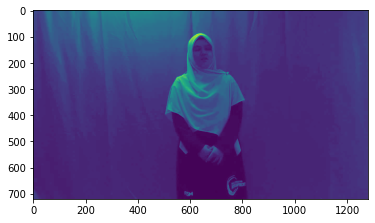

In [ ]:
plt.imshow(full_images[0])

xmin: 0.5094407200813293
ymin: 0.09208694100379944
width: 0.07119196653366089
height: 0.12659195065498352

xmin: 0.5053090453147888
ymin: 0.09213823080062866
width: 0.0827016830444336
height: 0.14702743291854858



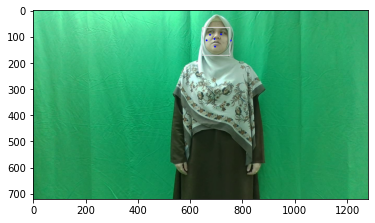

In [ ]:
with mp_face_detection.FaceDetection(
    min_detection_confidence=0.5, model_selection=1) as face_detection:
  for image in imgs[:2]:
    # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
    results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw face detections of each face.
    if not results.detections:
      print('gay')
      continue
    annotated_image = image.copy()
    for detection in results.detections:
      print(detection.location_data.relative_bounding_box)
      mp_drawing.draw_detection(annotated_image, detection)
    plt.imshow(annotated_image)

#Custom Data Generation

In [ ]:
code = full_dataframe['label'].unique()
integer_mapping = {x: i for i,x in enumerate(code)}

In [ ]:
from skimage.feature import hog
from skimage import exposure


fd, hog_image = hog(imgs[1], orientations=10, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)


(720, 1280, 3)


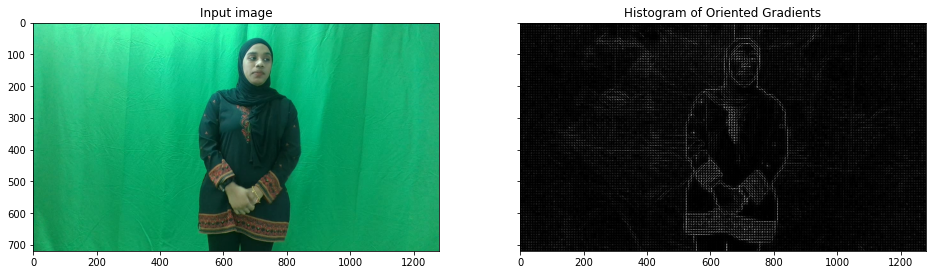

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(imgs[1], cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 20)) 
hog_image_rescaled = cv2.merge([hog_image_rescaled,hog_image_rescaled,hog_image_rescaled])
print(hog_image_rescaled.shape)

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

In [ ]:
import typing
def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> typing.Union[None, typing.Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px

In [ ]:
import tensorflow as tf
from PIL import Image

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, imgs,df, X_col, y_col,
                 batch_size,
                 input_size=(640, 640, 3),
                 shuffle=False):
        self.imgs = imgs
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_label = df[y_col['label']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self,img,Xbbox,Ybbox,Wbbox,Hbbox,target_size):
        xmin, ymin, w, h = Xbbox,Ybbox,Wbbox,Hbbox
        yolo_bbox1 = (xmin,ymin,w,h)
        W, H = 1280, 720
        rect_start_point = _normalized_to_pixel_coordinates(
        xmin, ymin, W,H)

        rect_end_point = _normalized_to_pixel_coordinates(
        xmin + w,
        ymin + h, W, H)  
        image_arr = tf.keras.preprocessing.image.img_to_array(img)
        if not(rect_start_point is None or rect_end_point is None):
        
          image_arr = image_arr[rect_start_point[1]:rect_end_point[1],rect_start_point[0]:rect_end_point[0],]

        image_arr = tf.image.resize(image_arr,(target_size[0],target_size[1])).numpy()
        image_arr = image_arr.astype(np.uint8)
        # image_arr = Image.fromarray(image_arr)
        # fd, hog_image = hog(image_arr, orientations=9, pixels_per_cell=(8, 8), 
        #             cells_per_block=(2, 2), visualize=True, multichannel=True)
        # hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 
        # hog_image_rescaled = cv2.merge([hog_image_rescaled,hog_image_rescaled,hog_image_rescaled])

        # hog_image_rescaled.shape 
        return image_arr
    
    def __get_output(self, label, num_classes):
        label = integer_mapping[label]
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, imgs,batches):
        # Generates data containing batch_size samples

        imgs_batch = imgs
        
        label_batch = batches[self.y_col['label']]
        Xbbox_batch = batches[self.X_col['x']]
        Ybbox_batch = batches[self.X_col['y']]
        Wbbox_batch = batches[self.X_col['w']]
        Hbbox_batch = batches[self.X_col['h']]

        X_batch = np.asarray([self.__get_input(img,Xbbox,Ybbox,Wbbox,Hbbox,self.input_size) for img,Xbbox,Ybbox,Wbbox,Hbbox in zip(imgs_batch,Xbbox_batch,Ybbox_batch,Wbbox_batch,Hbbox_batch)])
        y_batch = np.asarray([self.__get_output(y, self.n_label) for y in label_batch])

        return X_batch, y_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        imgs_batches = self.imgs[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = self.__get_data(imgs_batches,batches)        
        return X, y
        
    def __len__(self):
        return self.n // self.batch_size

In [ ]:
interval = int(len(full_dataframe)*0.88)
traingen = CustomDataGen(df = full_dataframe[:interval],
                         imgs = full_images[:interval],
                         X_col={'x':'x', 'y': 'y','w':'w', 'h': 'h'},
                         y_col={'label': 'label'},
                         batch_size=8)

valgen = CustomDataGen(df = full_dataframe[interval:],
                         imgs = full_images[interval:],
                         X_col={'x':'x', 'y': 'y','w':'w', 'h': 'h'},
                         y_col={'label': 'label'},
                         batch_size=8)




In [ ]:
STEP_SIZE_TRAIN = traingen.n // traingen.batch_size
STEP_SIZE_VALID = valgen.n // valgen.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

2268
272


In [ ]:
traingen

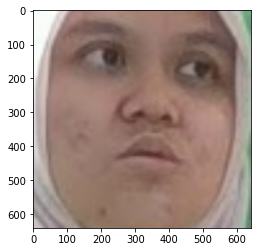

In [ ]:
plt.imshow(traingen[1][0][7],"PuRd")

In [ ]:
np.max(traingen[0][0][2])

255

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy

In [ ]:
# base_model = MobileNet( input_shape=(224,224,3), include_top= False )

# for layer in base_model.layers:
#   layer.trainable = False


# x = Flatten()(base_model.output)
# x = Dense(units=5 , activation='softmax' )(x)

# # creating our model.
# model = Model(base_model.input, x)

In [ ]:
# model.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )

# ## having early stopping and model check point 

# from keras.callbacks import ModelCheckpoint, EarlyStopping

# # early stopping
# es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# # model check point
# mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# # puting call back in a list 
# call_back = [es, mc]
# hist = model.fit_generator(traingen, 
#                            steps_per_epoch= STEP_SIZE_TRAIN,
#                            epochs= 30, 
#                            validation_data= valgen, 
#                            validation_steps= STEP_SIZE_VALID, 
#                            callbacks=call_back,
#                            verbose=1)

#Xception_expirement

##Load Model

In [ ]:
!mv /content/drive/MyDrive/train2.zip .
!unzip train2.zip
!mv train2.zip /content/drive/MyDrive

Archive:  train2.zip
   creating: content/Train2.0/
  inflating: content/Train2.0/Xception_on_DAiSEE_fc.h5  
   creating: content/Train2.0/logs/
   creating: content/Train2.0/logs/train/
  inflating: content/Train2.0/logs/train/events.out.tfevents.1670235521.ec198593ec26.114.2.v2  
  inflating: content/Train2.0/logs/train/events.out.tfevents.1670231301.ec198593ec26.114.0.v2  
  inflating: content/Train2.0/logs/train/events.out.tfevents.1670242964.ec198593ec26.114.6.v2  
  inflating: content/Train2.0/logs/train/events.out.tfevents.1670238673.ec198593ec26.114.4.v2  
   creating: content/Train2.0/logs/validation/
  inflating: content/Train2.0/logs/validation/events.out.tfevents.1670236170.ec198593ec26.114.3.v2  
  inflating: content/Train2.0/logs/validation/events.out.tfevents.1670231864.ec198593ec26.114.1.v2  
  inflating: content/Train2.0/logs/validation/events.out.tfevents.1670239244.ec198593ec26.114.5.v2  
  inflating: content/Train2.0/logs/validation/events.out.tfevents.1670243616.ec

In [ ]:
%cd content 
!mv * ..
%cd ..

/content/content
/content


In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/PresentationScoreModels/Xception_on_DAiSEE_finetune_fc.h5')

In [ ]:
from keras.models import Model

model2= Model(inputs=model.input, outputs=model.layers[-5].output)

In [ ]:
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 319, 319, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 319, 319, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
boredom = Dense(5, name="y1")(model2.output)
engagement = Dense(5, name="y2")(model2.output)
confusion = Dense(5, name="y3")(model2.output)
frustration = Dense(5, name="y4")(model2.output)
delight = Dense(5, name="y5")(model2.output)

model2 = Model(inputs=model2.input,
              outputs=[boredom, engagement, confusion, frustration, delight])

In [ ]:
model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 319, 319, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 319, 319, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

##Trian Model

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

finetune_at = 116
base_learning_rate = 0.00001
old_epoch = 0
epochs = 10

lr = base_learning_rate

model2.compile(optimizer=RMSprop(learning_rate=lr),
              loss={"y1": CategoricalCrossentropy(from_logits=True),
                    "y2": CategoricalCrossentropy(from_logits=True),
                    "y3": CategoricalCrossentropy(from_logits=True),
                    "y4": CategoricalCrossentropy(from_logits=True),
                    "y5": CategoricalCrossentropy(from_logits=True)},

              metrics={ "y1": "categorical_accuracy",
                        "y2": "categorical_accuracy",
                        "y3": "categorical_accuracy",
                        "y4": "categorical_accuracy",
                        "y5": "categorical_accuracy",
              })
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=1e-2,
                  patience=2, verbose=1),
    ModelCheckpoint(filepath="/content/drive/MyDrive/PresentationScoreModels/best_model.h5", monitor= 'val_loss', verbose= 1, save_best_only= True, mode = 'auto')
]

total_epochs = epochs 


In [ ]:
for layer in model2.layers[:-8]:
  layer.trainable = False

In [ ]:
for layer in model2.layers[:116]:
  layer.trainable = False
for layer in model2.layers[116:]:
  layer.trainable = True

In [ ]:
jhistory = model2.fit_generator(traingen,
                    steps_per_epoch= STEP_SIZE_TRAIN,
                    epochs= 30, 
                    validation_data= valgen, 
                    initial_epoch=old_epoch,
                    callbacks=callbacks,
                    validation_steps=STEP_SIZE_VALID,
                    verbose=1)

# model2.save('/content/drive/MyDrive/PresentationScoreModels/Daisee.h5')

Epoch 1/30


<ipython-input-146-fb0a0c7c0992>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(traingen,


2268/2268 [==============================] - ETA: 0s - loss: 7.4188 - y1_loss: 1.4689 - y2_loss: 1.4869 - y3_loss: 1.4882 - y4_loss: 1.4787 - y5_loss: 1.4960 - y1_categorical_accuracy: 0.3900 - y2_categorical_accuracy: 0.4064 - y3_categorical_accuracy: 0.3828 - y4_categorical_accuracy: 0.3779 - y5_categorical_accuracy: 0.3684
Epoch 1: val_loss improved from inf to 7.79739, saving model to /content/drive/MyDrive/best_model.h5
2268/2268 [==============================] - 267s 115ms/step - loss: 7.4188 - y1_loss: 1.4689 - y2_loss: 1.4869 - y3_loss: 1.4882 - y4_loss: 1.4787 - y5_loss: 1.4960 - y1_categorical_accuracy: 0.3900 - y2_categorical_accuracy: 0.4064 - y3_categorical_accuracy: 0.3828 - y4_categorical_accuracy: 0.3779 - y5_categorical_accuracy: 0.3684 - val_loss: 7.7974 - val_y1_loss: 1.5710 - val_y2_loss: 1.5057 - val_y3_loss: 1.5664 - val_y4_loss: 1.6092 - val_y5_loss: 1.5451 - val_y1_categorical_accuracy: 0.2757 - val_y2_categorical_accuracy: 0.2812 - val_y3_categorical_accuracy:

##Eval

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/PresentationScoreModels/best_model.h5')

In [ ]:
preds = model.evaluate_generator(valgen)

<ipython-input-59-cc05162371aa>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  preds = model.evaluate_generator(valgen)


In [ ]:
np.array(preds).min()

0

In [ ]:
pdf = full_dataframe[interval:],
pimgs = full_images[interval:],

In [ ]:
pimgs = np.array(pimgs).squeeze()

In [ ]:
pdf = np.array(pdf).squeeze()

In [ ]:
len(pdf),len(pimgs)

(2178, 2178)

In [ ]:
npdf = []
for pf in pdf:
  npdf.append(pf[1])

In [ ]:
len(npdf)

2178

In [ ]:
preds= []
pimages = []
for img in pimgs:
  img = cv2.resize(img,(640,640))
  # pred = np.argmax(model.predict(img[None]))

  pimages.append(img)

In [ ]:
model_result = model.evaluate(valgen)

272/272 [==============================] - 22s 81ms/step - loss: 6.1111 - y1_loss: 1.1604 - y2_loss: 1.2546 - y3_loss: 1.2625 - y4_loss: 1.2558 - y5_loss: 1.1778 - y1_categorical_accuracy: 0.5423 - y2_categorical_accuracy: 0.4959 - y3_categorical_accuracy: 0.4747 - y4_categorical_accuracy: 0.5069 - y5_categorical_accuracy: 0.5165


In [ ]:
class_names = ['Boredom', 'Engagement', 'Confusion', 'Frustration','delight']


def print_accuracy(result):
    """Print accuracy for all the classes."""
    print("Accuracy: ")
    for i, acc in enumerate(result[6:]):
        print(f"{class_names[i]}: {acc*100}")
    print(f"Model_accuracy: {np.array(result[6:]).mean()*100}")


In [ ]:
print_accuracy(model_result)

Accuracy: 
Boredom: 54.22794222831726
Engagement: 49.58639740943909
Confusion: 47.47242629528046
Frustration: 50.68933963775635
delight: 51.65441036224365
Model_accuracy: 50.72610318660736


##Final Model

In [ ]:
from keras.models import Model

model2= Model(inputs=model.input, outputs=model.layers[-6].output)

In [ ]:
model2.predict(pimages[100][None])

1/1 [==============================] - 1s 738ms/step


array([[1.583964  , 0.        , 0.        , 0.69478005, 0.        ,
        1.9715858 , 0.        , 1.6829331 , 1.0009438 , 0.8679207 ,
        0.4018705 , 1.2958362 , 0.33744556, 0.45135307, 0.2313449 ,
        1.0410991 , 0.        , 0.        , 1.113672  , 0.        ,
        2.6353946 , 0.        , 0.2577775 , 0.7981279 , 1.0721608 ,
        0.39867377, 0.        , 1.5332108 , 0.        , 1.3633888 ,
        0.        , 1.1751345 , 0.02373932, 0.        , 1.6872544 ,
        0.        , 0.58004355, 1.3325489 , 1.1744345 , 1.0376241 ,
        0.        , 0.43810284, 1.8921643 , 0.        , 0.        ,
        0.2701265 , 0.        , 1.0699443 , 0.9568399 , 1.2078265 ,
        0.        , 0.        , 1.5283116 , 0.        , 1.6839361 ,
        0.        , 0.63770455, 0.        , 0.35134104, 0.        ,
        2.5376916 , 0.        , 0.        , 0.38944784]], dtype=float32)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy

In [ ]:
base_model = model2

for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=5 , activation='softmax' )(x)

# creating our model.
model3 = Model(base_model.input, x)

In [ ]:
model3.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )

## having early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="/content/drive/MyDrive/PresentationScoreModels/best_model2.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]
hist = model3.fit_generator(traingen, 
                           steps_per_epoch= STEP_SIZE_TRAIN,
                           epochs= 30, 
                           validation_data= valgen, 
                           validation_steps= STEP_SIZE_VALID, 
                           callbacks=call_back,
                           verbose=1)

Epoch 1/30


<ipython-input-196-0ed7cd66c8a5>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model3.fit_generator(traingen,


2268/2268 [==============================] - ETA: 0s - loss: 1.2296 - accuracy: 0.5188
Epoch 1: val_accuracy improved from -inf to 0.58410, saving model to best_model2.h5
2268/2268 [==============================] - 187s 81ms/step - loss: 1.2296 - accuracy: 0.5188 - val_loss: 1.0524 - val_accuracy: 0.5841
Epoch 2/30
2268/2268 [==============================] - ETA: 0s - loss: 1.1250 - accuracy: 0.5624
Epoch 2: val_accuracy did not improve from 0.58410
2268/2268 [==============================] - 183s 81ms/step - loss: 1.1250 - accuracy: 0.5624 - val_loss: 1.0540 - val_accuracy: 0.5685
Epoch 3/30
2268/2268 [==============================] - ETA: 0s - loss: 1.0947 - accuracy: 0.5771
Epoch 3: val_accuracy improved from 0.58410 to 0.63925, saving model to best_model2.h5
2268/2268 [==============================] - 182s 80ms/step - loss: 1.0947 - accuracy: 0.5771 - val_loss: 1.0004 - val_accuracy: 0.6392
Epoch 4/30
2268/2268 [==============================] - ETA: 0s - loss: 1.0751 - accura

In [ ]:
!mv best_model2.h5 /content/drive/MyDrive

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/PresentationScoreModels/best_model2.h5')

##Results

In [ ]:
preds = model.predict(
    valgen ,
    batch_size=8,
    verbose="auto",
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

272/272 [==============================] - 22s 82ms/step


In [ ]:
int_mapping = {x: i for i,x in enumerate(class_names)}
labels = []
for label in npdf:
  label = integer_mapping[label]
  labels.append(label)


In [ ]:
labs = np.repeat(labels,8)

In [ ]:
len(labs)

17424

In [ ]:
# preds = []
# for img in pimages[:]:
#   img = img/255.
#   pred = np.argmax((model.predict(img[None]))[0])
#   print(pred)
#   preds.append(pred)
preds = model.predict(valgen, steps=valgen.n, workers=100)

2178/2178 [==============================] - 25s 11ms/step


In [ ]:
y_preds = []
for pred in preds:
  pred = np.argmax(pred)
  y_preds.append(pred)

In [ ]:
y_preds[50]

4

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
from sklearn.metrics import roc_curve, auc
import pandas as pd 

def plot_conf_matrix(true, pred, classes):
    cf = confusion_matrix(true, pred)
    plt.figure(figsize=(12,10))
    sns.set(font_scale=1.4)
    sns.heatmap(np.round(cf / cf.sum(axis=0), 3).T, annot=True, annot_kws={"size": 16},fmt='g',
                cmap='Blues', xticklabels = classes ,yticklabels = classes)
    plt.savefig('confusion_matrix.png')
    plt.savefig('confusion_matrix.svg')

    plt.show()


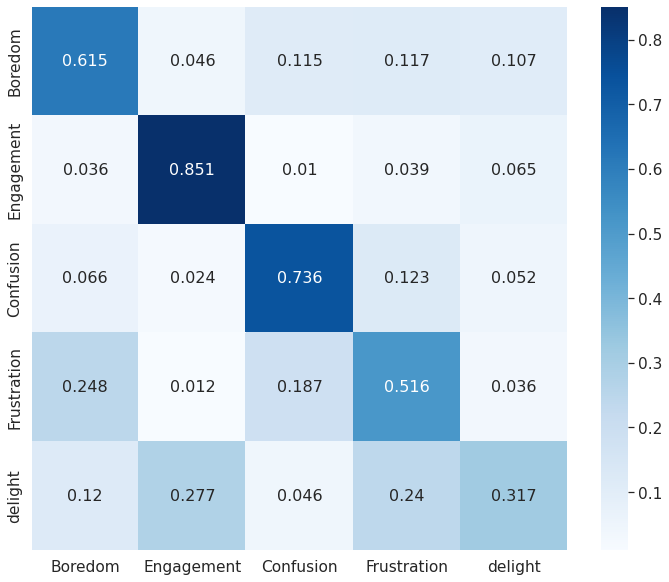

In [ ]:
plot_conf_matrix(labels, y_preds, class_names)

In [ ]:
 from sklearn.metrics import classification_report

print(classification_report(labels, y_preds, target_names=class_names))

              precision    recall  f1-score   support

     Boredom       0.62      0.62      0.62       478
  Engagement       0.85      0.83      0.84       748
   Confusion       0.74      0.50      0.60       311
 Frustration       0.52      0.52      0.52       406
     delight       0.32      0.47      0.38       235

    accuracy                           0.64      2178
   macro avg       0.61      0.59      0.59      2178
weighted avg       0.66      0.64      0.65      2178



ROC AUC score: 0.7489655940842457


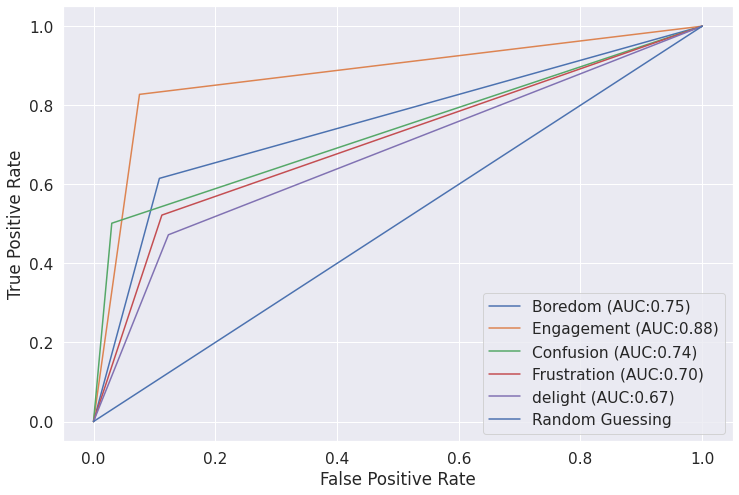

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score




# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(labels, y_preds))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig('ROC_Curve.png')
plt.savefig('ROC_Curve.svg')
plt.show()

In [ ]:
!mkdir presentation_results
!mv *.png presentation_results
!mv *.svg presentation_results
!mv presentation_results drive/MyDrive

#Inception_expirement

##Load Model

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Daisee/Presentation_Scoring_Models/Inception/Inception_on_DAiSEE_fc.h5')

In [ ]:
from keras.models import Model

model2= Model(inputs=model.input, outputs=model.layers[-5].output)

In [ ]:
model2.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_106 (Conv2D)            (None, 319, 319, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_106 (Batch  (None, 319, 319, 32  96         ['conv2d_106[0][0]']             
 Normalization)                 )                                                          

In [ ]:
boredom = Dense(5, name="y1")(model2.output)
engagement = Dense(5, name="y2")(model2.output)
confusion = Dense(5, name="y3")(model2.output)
frustration = Dense(5, name="y4")(model2.output)
delight = Dense(5, name="y5")(model2.output)

model2 = Model(inputs=model2.input,
              outputs=[boredom, engagement, confusion, frustration, delight])

In [ ]:
model2.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_106 (Conv2D)            (None, 319, 319, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_106 (Batch  (None, 319, 319, 32  96         ['conv2d_106[0][0]']             
 Normalization)                 )                                                          

##Train Model

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

finetune_at = 116
base_learning_rate = 0.0001
old_epoch = 0
epochs = 10

lr = base_learning_rate

model2.compile(optimizer=RMSprop(learning_rate=lr),
              loss={"y1": CategoricalCrossentropy(from_logits=True),
                    "y2": CategoricalCrossentropy(from_logits=True),
                    "y3": CategoricalCrossentropy(from_logits=True),
                    "y4": CategoricalCrossentropy(from_logits=True),
                    "y5": CategoricalCrossentropy(from_logits=True)},

              metrics={ "y1": "categorical_accuracy",
                        "y2": "categorical_accuracy",
                        "y3": "categorical_accuracy",
                        "y4": "categorical_accuracy",
                        "y5": "categorical_accuracy",
              })
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=1e-2,
                  patience=3, verbose=1),
    ModelCheckpoint(filepath="/content/drive/MyDrive/PresentationScoreModels/Inception_best_model.h5", monitor= 'val_loss', verbose= 1, save_best_only= True, mode = 'auto')
]

total_epochs = epochs 


In [ ]:
for layer in model2.layers[:-8]:
  layer.trainable = False

In [ ]:
for layer in model2.layers[-8:]:
  layer.trainable = True

In [ ]:
# for layer in model2.layers[:116]:
#   layer.trainable = False
# for layer in model2.layers[116:]:
#   layer.trainable = True

In [ ]:
history = model2.fit_generator(traingen,
                    steps_per_epoch= STEP_SIZE_TRAIN,
                    epochs= 30, 
                    validation_data= valgen, 
                    initial_epoch=old_epoch,
                    callbacks=callbacks,
                    validation_steps=STEP_SIZE_VALID,
                    verbose=1)

# model2.save('/content/drive/MyDrive/PresentationScoreModels/Daisee.h5')

Epoch 1/30


<ipython-input-212-a3f0cbdcbe06>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(traingen,


2268/2268 [==============================] - ETA: 0s - loss: 9.8818 - y1_loss: 2.1046 - y2_loss: 1.7539 - y3_loss: 2.0306 - y4_loss: 1.9444 - y5_loss: 2.0484 - y1_categorical_accuracy: 0.2832 - y2_categorical_accuracy: 0.3256 - y3_categorical_accuracy: 0.3133 - y4_categorical_accuracy: 0.2868 - y5_categorical_accuracy: 0.2868
Epoch 1: val_loss improved from inf to 7.67181, saving model to /content/drive/MyDrive/PresentationScoreModels/Inception_best_model.h5
2268/2268 [==============================] - 179s 76ms/step - loss: 9.8818 - y1_loss: 2.1046 - y2_loss: 1.7539 - y3_loss: 2.0306 - y4_loss: 1.9444 - y5_loss: 2.0484 - y1_categorical_accuracy: 0.2832 - y2_categorical_accuracy: 0.3256 - y3_categorical_accuracy: 0.3133 - y4_categorical_accuracy: 0.2868 - y5_categorical_accuracy: 0.2868 - val_loss: 7.6718 - val_y1_loss: 1.3374 - val_y2_loss: 1.5128 - val_y3_loss: 1.7697 - val_y4_loss: 1.3571 - val_y5_loss: 1.6948 - val_y1_categorical_accuracy: 0.5257 - val_y2_categorical_accuracy: 0.40

##Eval

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/PresentationScoreModels/Inception_best_model.h5')

In [ ]:
preds = model.evaluate_generator(valgen)

<ipython-input-214-cc05162371aa>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  preds = model.evaluate_generator(valgen)


In [ ]:
np.array(preds).min()

0.5752984285354614

In [ ]:
pdf = full_dataframe[interval:],
pimgs = full_images[interval:],

In [ ]:
pimgs = np.array(pimgs).squeeze()

In [ ]:
pdf = np.array(pdf).squeeze()

In [ ]:
len(pdf),len(pimgs)

(2178, 2178)

In [ ]:
npdf = []
for pf in pdf:
  npdf.append(pf[1])

In [ ]:
len(npdf)

2178

In [ ]:
preds= []
pimages = []
for img in pimgs:
  img = cv2.resize(img,(640,640))
  # pred = np.argmax(model.predict(img[None]))

  pimages.append(img)

In [ ]:
model_result = model.evaluate(valgen)

2178/2178 [==============================] - 47s 22ms/step - loss: 5.6207 - y1_loss: 1.1420 - y2_loss: 1.1231 - y3_loss: 1.0989 - y4_loss: 1.1073 - y5_loss: 1.1494 - y1_categorical_accuracy: 0.5767 - y2_categorical_accuracy: 0.5900 - y3_categorical_accuracy: 0.5937 - y4_categorical_accuracy: 0.5753 - y5_categorical_accuracy: 0.5863


In [ ]:
class_names = ['Boredom', 'Engagement', 'Confusion', 'Frustration','delight']


def print_accuracy(result):
    """Print accuracy for all the classes."""
    print("Accuracy: ")
    for i, acc in enumerate(result[6:]):
        print(f"{class_names[i]}: {acc*100}")
    print(f"Model_accuracy: {np.array(result[6:]).mean()*100}")


In [ ]:
print_accuracy(model_result)

Accuracy: 
Boredom: 57.66758322715759
Engagement: 58.99907946586609
Confusion: 59.366393089294434
Frustration: 57.52984285354614
delight: 58.63177180290222
Model_accuracy: 58.43893408775329


##Final Model

In [ ]:
from keras.models import Model

model2= Model(inputs=model.input, outputs=model.layers[-6].output)

In [ ]:
model2.predict(pimages[100][None])

1/1 [==============================] - 1s 1s/step


array([[12.1403675 ,  0.        ,  0.        ,  9.851392  ,  0.        ,
         0.        ,  8.233662  ,  0.        ,  1.279655  ,  2.1943007 ,
         0.        ,  0.48432356,  0.        ,  0.        ,  4.0726266 ,
         1.2447344 ,  7.43366   ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 14.207336  , 14.868328  ,
         0.        ,  0.        ,  6.715471  ,  3.9324644 ,  0.        ,
        10.558976  ,  3.2852726 ,  0.        ,  0.        ,  2.6846879 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.3695372 ,  0.        ,  0.        ,  0.        ,
         0.        ,  7.2115107 ,  0.        ,  0.        ,  2.6258624 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  2.8891954 ,  9.646726  ,
         0.        ,  0.        ,  8.181852  ,  0.        ]],
      dtype=float32)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy

In [ ]:
base_model = model2

for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=5 , activation='softmax' )(x)

# creating our model.
model3 = Model(base_model.input, x)

In [ ]:
model3.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )

## having early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="/content/drive/MyDrive/PresentationScoreModels/Inception_best_model_final.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]
hist = model3.fit_generator(traingen, 
                           steps_per_epoch= STEP_SIZE_TRAIN,
                           epochs= 30, 
                           validation_data= valgen, 
                           validation_steps= STEP_SIZE_VALID, 
                           callbacks=call_back,
                           verbose=1)

Epoch 1/30


<ipython-input-231-39a05d745653>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model3.fit_generator(traingen,


2268/2268 [==============================] - ETA: 0s - loss: 1.3751 - accuracy: 0.4707
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to /content/drive/MyDrive/PresentationScoreModels/Inception_best_model_final.h5
2268/2268 [==============================] - 187s 81ms/step - loss: 1.3751 - accuracy: 0.4707 - val_loss: 1.3489 - val_accuracy: 0.5625
Epoch 2/30
2268/2268 [==============================] - ETA: 0s - loss: 1.1085 - accuracy: 0.5691
Epoch 2: val_accuracy improved from 0.56250 to 0.56618, saving model to /content/drive/MyDrive/PresentationScoreModels/Inception_best_model_final.h5
2268/2268 [==============================] - 185s 82ms/step - loss: 1.1085 - accuracy: 0.5691 - val_loss: 1.1728 - val_accuracy: 0.5662
Epoch 3/30
2268/2268 [==============================] - ETA: 0s - loss: 1.0860 - accuracy: 0.5822
Epoch 3: val_accuracy did not improve from 0.56618
2268/2268 [==============================] - 185s 81ms/step - loss: 1.0860 - accuracy: 0.5822 - val

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/PresentationScoreModels/Inception_best_model_final.h5')

##Results

In [ ]:
preds = model.predict(
    valgen ,
    batch_size=8,
    verbose="auto",
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

2178/2178 [==============================] - 39s 17ms/step


In [ ]:
int_mapping = {x: i for i,x in enumerate(class_names)}
labels = []
for label in npdf:
  label = integer_mapping[label]
  labels.append(label)


In [ ]:
labs = np.repeat(labels,8)

In [ ]:
len(labs)

17424

In [ ]:
# preds = []
# for img in pimages[:]:
#   img = img/255.
#   pred = np.argmax((model.predict(img[None]))[0])
#   print(pred)
#   preds.append(pred)
preds = model.predict(valgen, steps=valgen.n, workers=100)

2178/2178 [==============================] - 40s 18ms/step


In [ ]:
y_preds = []
for pred in preds:
  pred = np.argmax(pred)
  y_preds.append(pred)

In [ ]:
y_preds[50]

1

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
from sklearn.metrics import roc_curve, auc
import pandas as pd 

def plot_conf_matrix(true, pred, classes):
    cf = confusion_matrix(true, pred)
    plt.figure(figsize=(12,10))
    sns.set(font_scale=1.4)
    sns.heatmap(np.round(cf / cf.sum(axis=0), 3).T, annot=True, annot_kws={"size": 16},fmt='g',
                cmap='Blues', xticklabels = classes ,yticklabels = classes)
    plt.savefig('confusion_matrix.png')
    plt.savefig('confusion_matrix.svg')

    plt.show()


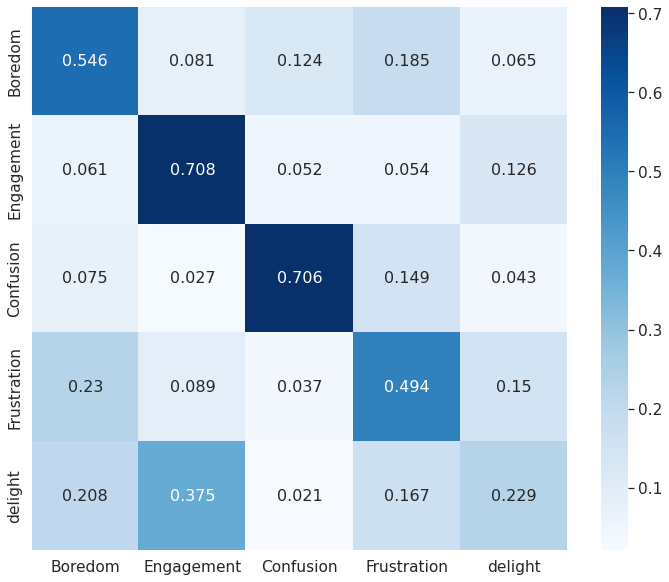

In [ ]:
plot_conf_matrix(labels, y_preds, class_names)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, y_preds, target_names=class_names))

              precision    recall  f1-score   support

     Boredom       0.55      0.62      0.58       478
  Engagement       0.71      0.86      0.78       748
   Confusion       0.71      0.58      0.64       311
 Frustration       0.49      0.52      0.51       406
     delight       0.23      0.05      0.08       235

    accuracy                           0.61      2178
   macro avg       0.54      0.52      0.52      2178
weighted avg       0.58      0.61      0.59      2178



ROC AUC score: 0.7110358967158767


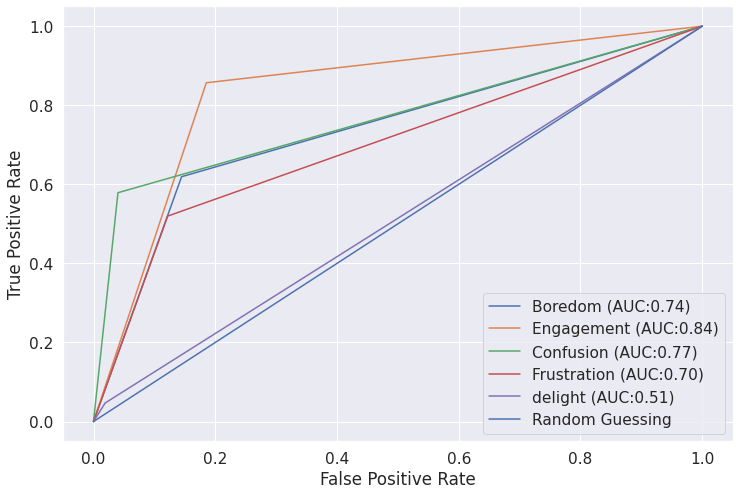

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score




# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(labels, y_preds))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig('ROC_Curve.png')
plt.savefig('ROC_Curve.svg')
plt.show()

In [ ]:
!mkdir presentation_results_Inception
!mv *.png presentation_results_Inception
!mv *.svg presentation_results_Inception
!mv presentation_results_Inception drive/MyDrive

#ResNet_expirement

##Load Model

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Daisee/Presentation_Scoring_Models/ResNet/ResNet_on_DAiSEE_fc.h5')

In [ ]:
from keras.models import Model

model2= Model(inputs=model.input, outputs=model.layers[-5].output)

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 646, 646, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 320, 320, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
boredom = Dense(5, name="y1")(model2.output)
engagement = Dense(5, name="y2")(model2.output)
confusion = Dense(5, name="y3")(model2.output)
frustration = Dense(5, name="y4")(model2.output)
delight = Dense(5, name="y5")(model2.output)

model2 = Model(inputs=model2.input,
              outputs=[boredom, engagement, confusion, frustration, delight])

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 646, 646, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 320, 320, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

##Trian Model

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

finetune_at = 116
base_learning_rate = 0.0001
old_epoch = 0
epochs = 10

lr = base_learning_rate

model2.compile(optimizer=RMSprop(learning_rate=lr),
              loss={"y1": CategoricalCrossentropy(from_logits=True),
                    "y2": CategoricalCrossentropy(from_logits=True),
                    "y3": CategoricalCrossentropy(from_logits=True),
                    "y4": CategoricalCrossentropy(from_logits=True),
                    "y5": CategoricalCrossentropy(from_logits=True)},

              metrics={ "y1": "categorical_accuracy",
                        "y2": "categorical_accuracy",
                        "y3": "categorical_accuracy",
                        "y4": "categorical_accuracy",
                        "y5": "categorical_accuracy",
              })
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=1e-2,
                  patience=2, verbose=1),
    ModelCheckpoint(filepath="/content/drive/MyDrive/PresentationScoreModels/ResNet_best_model.h5", monitor= 'val_loss', verbose= 1, save_best_only= True, mode = 'auto')
]

total_epochs = epochs 


In [ ]:
for layer in model2.layers[:-8]:
  layer.trainable = False
for layer in model2.layers[-8:]:
  layer.trainable = True

In [ ]:
# for layer in model2.layers[:116]:
#   layer.trainable = False
# for layer in model2.layers[116:]:
#   layer.trainable = True

In [ ]:
history = model2.fit_generator(traingen,
                    steps_per_epoch= STEP_SIZE_TRAIN,
                    epochs= 30, 
                    validation_data= valgen, 
                    initial_epoch=old_epoch,
                    callbacks=callbacks,
                    validation_steps=STEP_SIZE_VALID,
                    verbose=1)

# model2.save('/content/drive/MyDrive/PresentationScoreModels/Daisee.h5')

<ipython-input-72-a3f0cbdcbe06>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(traingen,


Epoch 1/30
2268/2268 [==============================] - ETA: 0s - loss: 40.8840 - y1_loss: 10.4816 - y2_loss: 7.7819 - y3_loss: 8.0539 - y4_loss: 7.6786 - y5_loss: 6.8879 - y1_categorical_accuracy: 0.2278 - y2_categorical_accuracy: 0.2524 - y3_categorical_accuracy: 0.2621 - y4_categorical_accuracy: 0.2451 - y5_categorical_accuracy: 0.2451
Epoch 1: val_loss improved from inf to 15.61307, saving model to /content/drive/MyDrive/PresentationScoreModels/ResNet_best_model.h5
2268/2268 [==============================] - 184s 76ms/step - loss: 40.8840 - y1_loss: 10.4816 - y2_loss: 7.7819 - y3_loss: 8.0539 - y4_loss: 7.6786 - y5_loss: 6.8879 - y1_categorical_accuracy: 0.2278 - y2_categorical_accuracy: 0.2524 - y3_categorical_accuracy: 0.2621 - y4_categorical_accuracy: 0.2451 - y5_categorical_accuracy: 0.2451 - val_loss: 15.6131 - val_y1_loss: 2.5331 - val_y2_loss: 4.3835 - val_y3_loss: 3.1222 - val_y4_loss: 2.6960 - val_y5_loss: 2.8783 - val_y1_categorical_accuracy: 0.2909 - val_y2_categorical_

##Eval

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/PresentationScoreModels/ResNet_best_model.h5')

In [ ]:
preds = model.evaluate_generator(valgen)

<ipython-input-74-cc05162371aa>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  preds = model.evaluate_generator(valgen)


In [ ]:
np.array(preds).min()

0.11397058516740799

In [ ]:
pdf = full_dataframe[interval:],
pimgs = full_images[interval:],

In [ ]:
pimgs = np.array(pimgs).squeeze()

In [ ]:
pdf = np.array(pdf).squeeze()

In [ ]:
len(pdf),len(pimgs)

(2178, 2178)

In [ ]:
npdf = []
for pf in pdf:
  npdf.append(pf[1])

In [ ]:
len(npdf)

2178

In [ ]:
preds= []
pimages = []
for img in pimgs:
  img = cv2.resize(img,(640,640))
  # pred = np.argmax(model.predict(img[None]))

  pimages.append(img)

In [ ]:
model_result = model.evaluate(valgen)

272/272 [==============================] - 19s 69ms/step - loss: 11.5504 - y1_loss: 2.6580 - y2_loss: 2.0893 - y3_loss: 1.8926 - y4_loss: 2.7759 - y5_loss: 2.1345 - y1_categorical_accuracy: 0.2238 - y2_categorical_accuracy: 0.1875 - y3_categorical_accuracy: 0.2891 - y4_categorical_accuracy: 0.1140 - y5_categorical_accuracy: 0.3828


In [ ]:
class_names = ['Boredom', 'Engagement', 'Confusion', 'Frustration','delight']


def print_accuracy(result):
    """Print accuracy for all the classes."""
    print("Accuracy: ")
    for i, acc in enumerate(result[6:]):
        print(f"{class_names[i]}: {acc*100}")
    print(f"Model_accuracy: {np.array(result[6:]).mean()*100}")


In [ ]:
print_accuracy(model_result)

Accuracy: 
Boredom: 22.380514442920685
Engagement: 18.75
Confusion: 28.90625
Frustration: 11.397058516740799
delight: 38.28125
Model_accuracy: 23.943014591932297


##Final Model

In [ ]:
from keras.models import Model

model2= Model(inputs=model.input, outputs=model.layers[-6].output)

In [ ]:
model2.predict(pimages[100][None])

1/1 [==============================] - 1s 1s/step


array([[ 0.       , 65.76082  ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       , 17.11027  ,  0.       ,
        52.088287 ,  0.       ,  0.       ,  0.       ,  0.       ,
        40.758476 ,  4.4834714,  0.       ,  0.       ,  0.       ,
        13.717462 ,  0.       , 47.2825   ,  0.       , 52.869484 ,
         0.       ,  0.       , 17.385546 , 21.153606 ,  0.       ,
         0.       , 18.259216 ,  0.       ,  0.       ,  0.       ,
         0.       , 68.4698   ,  0.       ,  0.       ,  0.       ,
         0.       ,  7.2320995, 36.10216  ,  0.       ,  0.       ,
         0.       , 31.365807 ,  0.       ,  0.       ,  0.       ,
        22.048286 , 46.518963 ,  0.       ,  0.       , 33.464115 ,
         0.       , 62.80077  ,  0.       ,  0.       ]], dtype=float32)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy

In [ ]:
base_model = model2

for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=5 , activation='softmax' )(x)

# creating our model.
model3 = Model(base_model.input, x)

In [ ]:
model3.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )

## having early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="/content/drive/MyDrive/PresentationScoreModels/ResNet_best_model_final.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]
hist = model3.fit_generator(traingen, 
                           steps_per_epoch= STEP_SIZE_TRAIN,
                           epochs= 30, 
                           validation_data= valgen, 
                           validation_steps= STEP_SIZE_VALID, 
                           callbacks=call_back,
                           verbose=1)

Epoch 1/30


<ipython-input-104-313b296ab161>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model3.fit_generator(traingen,


2268/2268 [==============================] - ETA: 0s - loss: 3.2072 - accuracy: 0.2250
Epoch 1: val_accuracy improved from -inf to 0.13603, saving model to /content/drive/MyDrive/PresentationScoreModels/ResNet_best_model_final.h5
2268/2268 [==============================] - 162s 70ms/step - loss: 3.2072 - accuracy: 0.2250 - val_loss: 2.0235 - val_accuracy: 0.1360
Epoch 2/30
2268/2268 [==============================] - ETA: 0s - loss: 1.9322 - accuracy: 0.2745
Epoch 2: val_accuracy did not improve from 0.13603
2268/2268 [==============================] - 155s 68ms/step - loss: 1.9322 - accuracy: 0.2745 - val_loss: 2.7426 - val_accuracy: 0.0368
Epoch 3/30
2268/2268 [==============================] - ETA: 0s - loss: 1.7621 - accuracy: 0.3061
Epoch 3: val_accuracy improved from 0.13603 to 0.22059, saving model to /content/drive/MyDrive/PresentationScoreModels/ResNet_best_model_final.h5
2268/2268 [==============================] - 159s 70ms/step - loss: 1.7621 - accuracy: 0.3061 - val_loss:

##Results

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/PresentationScoreModels/ResNet_best_model_final.h5')

In [ ]:
preds = model.predict(
    valgen ,
    batch_size=8,
    verbose="auto",
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

2178/2178 [==============================] - 26s 12ms/step


In [ ]:
int_mapping = {x: i for i,x in enumerate(class_names)}
labels = []
for label in npdf:
  label = integer_mapping[label]
  labels.append(label)


In [ ]:
labs = np.repeat(labels,8)

In [ ]:
len(labs)

17424

In [ ]:
# preds = []
# for img in pimages[:]:
#   img = img/255.
#   pred = np.argmax((model.predict(img[None]))[0])
#   print(pred)
#   preds.append(pred)
preds = model.predict(valgen, steps=valgen.n, workers=100)

2178/2178 [==============================] - 26s 12ms/step


In [ ]:
y_preds = []
for pred in preds:
  pred = np.argmax(pred)
  y_preds.append(pred)

In [ ]:
y_preds[50]

1

In [17]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
from sklearn.metrics import roc_curve, auc
import pandas as pd 

def plot_conf_matrix(true, pred, classes):
    cf = confusion_matrix(true, pred)
    plt.figure(figsize=(12,10))
    sns.set(font_scale=1.4)
    sns.heatmap(np.round(cf / cf.sum(axis=0), 3).T, annot=True, annot_kws={"size": 16},fmt='g',
                cmap='Blues', xticklabels = classes ,yticklabels = classes)
    plt.savefig('confusion_matrix.png')
    plt.savefig('confusion_matrix.svg')

    plt.show()


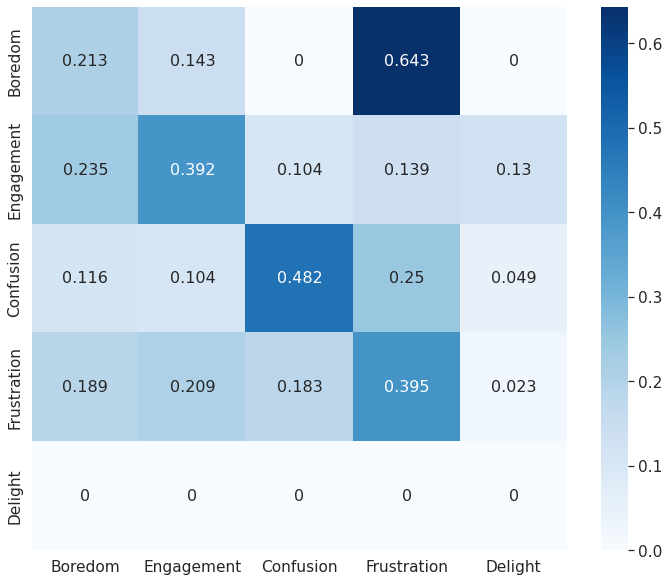

In [18]:
plot_conf_matrix(labels, y_preds, class_names)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, y_preds, target_names=class_names))

              precision    recall  f1-score   support

     Boredom       0.21      0.01      0.01       478
  Engagement       0.39      0.89      0.54       748
   Confusion       0.48      0.25      0.33       311
 Frustration       0.40      0.29      0.34       406
     delight       0.00      0.00      0.00       235

    accuracy                           0.40      2178
   macro avg       0.30      0.29      0.25      2178
weighted avg       0.32      0.40      0.30      2178



ROC AUC score: 0.5566873257134377


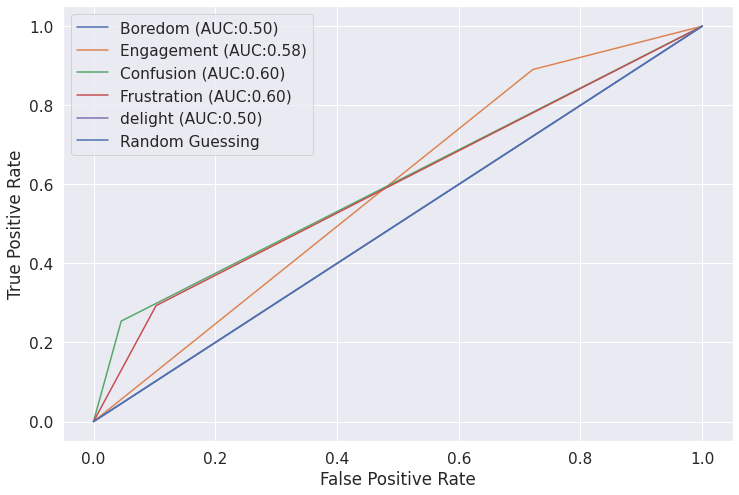

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score




# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(labels, y_preds))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig('ROC_Curve.png')
plt.savefig('ROC_Curve.svg')
plt.show()

In [ ]:
!mkdir presentation_results_ResNet
!mv *.png presentation_results_ResNet
!mv *.svg presentation_results_ResNet
!mv presentation_results_ResNet drive/MyDrive

#MobileNet_expirement

##Load Model

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Daisee/Presentation_Scoring_Models/MobileNet/MobileNet_on_DAiSEE_fc.h5')

In [ ]:
from keras.models import Model

model2= Model(inputs=model.input, outputs=model.layers[-5].output)

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 320, 320, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 320, 320, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
boredom = Dense(5, name="y1")(model2.output)
engagement = Dense(5, name="y2")(model2.output)
confusion = Dense(5, name="y3")(model2.output)
frustration = Dense(5, name="y4")(model2.output)
delight = Dense(5, name="y5")(model2.output)

model2 = Model(inputs=model2.input,
              outputs=[boredom, engagement, confusion, frustration, delight])

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 320, 320, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 320, 320, 32  128         ['Conv1[0][0]']                  
                                )                                                           

##Trian Model

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

finetune_at = 116
base_learning_rate = 0.00001
old_epoch = 0
epochs = 10

lr = base_learning_rate

model2.compile(optimizer=RMSprop(learning_rate=lr),
              loss={"y1": CategoricalCrossentropy(from_logits=True),
                    "y2": CategoricalCrossentropy(from_logits=True),
                    "y3": CategoricalCrossentropy(from_logits=True),
                    "y4": CategoricalCrossentropy(from_logits=True),
                    "y5": CategoricalCrossentropy(from_logits=True)},

              metrics={ "y1": "categorical_accuracy",
                        "y2": "categorical_accuracy",
                        "y3": "categorical_accuracy",
                        "y4": "categorical_accuracy",
                        "y5": "categorical_accuracy",
              })
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=1e-2,
                  patience=2, verbose=1),
    ModelCheckpoint(filepath="/content/drive/MyDrive/PresentationScoreModels/MobileNet_best_model.h5", monitor= 'val_loss', verbose= 1, save_best_only= True, mode = 'auto')
]

total_epochs = epochs 


In [ ]:
for layer in model2.layers[:-8]:
  layer.trainable = False
for layer in model2.layers[-8:]:
  layer.trainable = True

In [ ]:
# for layer in model2.layers[:116]:
#   layer.trainable = False
# for layer in model2.layers[116:]:
#   layer.trainable = True

In [ ]:
jhistory = model2.fit_generator(traingen,
                    steps_per_epoch= STEP_SIZE_TRAIN,
                    epochs= 30, 
                    validation_data= valgen, 
                    initial_epoch=old_epoch,
                    callbacks=callbacks,
                    validation_steps=STEP_SIZE_VALID,
                    verbose=1)

# model2.save('/content/drive/MyDrive/PresentationScoreModels/Daisee.h5')

Epoch 1/30


<ipython-input-78-bff6b5c33b61>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  jhistory = model2.fit_generator(traingen,


2268/2268 [==============================] - ETA: 0s - loss: 7.4794 - y1_loss: 1.4895 - y2_loss: 1.4917 - y3_loss: 1.5175 - y4_loss: 1.4850 - y5_loss: 1.4958 - y1_categorical_accuracy: 0.3336 - y2_categorical_accuracy: 0.3494 - y3_categorical_accuracy: 0.3151 - y4_categorical_accuracy: 0.3532 - y5_categorical_accuracy: 0.3521
Epoch 1: val_loss improved from inf to 7.60282, saving model to /content/drive/MyDrive/PresentationScoreModels/MobileNet_best_model.h5
2268/2268 [==============================] - 164s 71ms/step - loss: 7.4794 - y1_loss: 1.4895 - y2_loss: 1.4917 - y3_loss: 1.5175 - y4_loss: 1.4850 - y5_loss: 1.4958 - y1_categorical_accuracy: 0.3336 - y2_categorical_accuracy: 0.3494 - y3_categorical_accuracy: 0.3151 - y4_categorical_accuracy: 0.3532 - y5_categorical_accuracy: 0.3521 - val_loss: 7.6028 - val_y1_loss: 1.5025 - val_y2_loss: 1.5220 - val_y3_loss: 1.5464 - val_y4_loss: 1.5160 - val_y5_loss: 1.5158 - val_y1_categorical_accuracy: 0.3516 - val_y2_categorical_accuracy: 0.35

##Eval

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/PresentationScoreModels/MobileNet_best_model.h5')

In [ ]:
preds = model.evaluate_generator(valgen)

<ipython-input-80-cc05162371aa>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  preds = model.evaluate_generator(valgen)


In [ ]:
np.array(preds).min()

0.3538602888584137

In [ ]:
pdf = full_dataframe[interval:],
pimgs = full_images[interval:],

In [ ]:
pimgs = np.array(pimgs).squeeze()

In [ ]:
pdf = np.array(pdf).squeeze()

In [ ]:
len(pdf),len(pimgs)

(2178, 2178)

In [ ]:
npdf = []
for pf in pdf:
  npdf.append(pf[1])

In [ ]:
len(npdf)

2178

In [ ]:
preds= []
pimages = []
for img in pimgs:
  img = cv2.resize(img,(640,640))
  # pred = np.argmax(model.predict(img[None]))

  pimages.append(img)

In [ ]:
model_result = model.evaluate(valgen)

272/272 [==============================] - 17s 62ms/step - loss: 7.5035 - y1_loss: 1.4783 - y2_loss: 1.5034 - y3_loss: 1.5327 - y4_loss: 1.5041 - y5_loss: 1.4850 - y1_categorical_accuracy: 0.3617 - y2_categorical_accuracy: 0.3837 - y3_categorical_accuracy: 0.3539 - y4_categorical_accuracy: 0.3994 - y5_categorical_accuracy: 0.3644


In [ ]:
class_names = ['Boredom', 'Engagement', 'Confusion', 'Frustration','delight']


def print_accuracy(result):
    """Print accuracy for all the classes."""
    print("Accuracy: ")
    for i, acc in enumerate(result[6:]):
        print(f"{class_names[i]}: {acc*100}")
    print(f"Model_accuracy: {np.array(result[6:]).mean()*100}")


In [ ]:
print_accuracy(model_result)

Accuracy: 
Boredom: 36.16727888584137
Engagement: 38.37316036224365
Confusion: 35.38602888584137
Frustration: 39.93566036224365
delight: 36.443015933036804
Model_accuracy: 37.26102888584137


##Final Model

In [ ]:
from keras.models import Model

model2= Model(inputs=model.input, outputs=model.layers[-6].output)

In [ ]:
model2.predict(pimages[100][None])

1/1 [==============================] - 1s 969ms/step


array([[0.        , 0.        , 0.        , 0.05645816, 0.        ,
        1.3141574 , 0.        , 0.        , 0.        , 0.33807573,
        0.        , 0.20244722, 0.        , 1.0078582 , 1.166278  ,
        0.        , 1.9586624 , 0.5253249 , 1.388867  , 0.        ,
        1.574054  , 0.        , 2.258365  , 0.        , 1.5838364 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        3.0452945 , 0.        , 1.3838159 , 0.        , 0.        ,
        1.1777345 , 0.        , 0.        , 0.48720038, 1.4172219 ,
        0.        , 0.        , 0.        , 1.4065254 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.2933317 ,
        0.        , 0.        , 1.8693018 , 0.63237375, 0.45056492,
        0.8272671 , 0.5408875 , 0.        , 0.01247002, 2.7191412 ,
        0.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy

In [ ]:
base_model = model2

for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=5 , activation='softmax' )(x)

# creating our model.
model3 = Model(base_model.input, x)

In [ ]:
model3.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )

## having early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="/content/drive/MyDrive/PresentationScoreModels/MobileNet_best_model_final.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]
hist = model3.fit_generator(traingen, 
                           steps_per_epoch= STEP_SIZE_TRAIN,
                           epochs= 30, 
                           validation_data= valgen, 
                           validation_steps= STEP_SIZE_VALID, 
                           callbacks=call_back,
                           verbose=1)

Epoch 1/30


<ipython-input-97-ac9033373b8d>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model3.fit_generator(traingen,


2268/2268 [==============================] - ETA: 0s - loss: 1.5435 - accuracy: 0.2939
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to /content/drive/MyDrive/PresentationScoreModels/MobileNet_best_model_final.h5
2268/2268 [==============================] - 143s 62ms/step - loss: 1.5435 - accuracy: 0.2939 - val_loss: 1.5377 - val_accuracy: 0.1250
Epoch 2/30
2268/2268 [==============================] - ETA: 0s - loss: 1.4374 - accuracy: 0.3802
Epoch 2: val_accuracy improved from 0.12500 to 0.32353, saving model to /content/drive/MyDrive/PresentationScoreModels/MobileNet_best_model_final.h5
2268/2268 [==============================] - 141s 62ms/step - loss: 1.4374 - accuracy: 0.3802 - val_loss: 1.5042 - val_accuracy: 0.3235
Epoch 3/30
2268/2268 [==============================] - ETA: 0s - loss: 1.4091 - accuracy: 0.4013
Epoch 3: val_accuracy did not improve from 0.32353
2268/2268 [==============================] - 140s 62ms/step - loss: 1.4091 - accuracy: 0.4013 - val

In [ ]:
!mv best_model2.h5 /content/drive/MyDrive

mv: cannot stat 'best_model2.h5': No such file or directory


In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/PresentationScoreModels/MobileNet_best_model_final.h5')

##Results

In [ ]:
preds = model.predict(
    valgen ,
    batch_size=8,
    verbose="auto",
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

2178/2178 [==============================] - 22s 10ms/step


In [ ]:
int_mapping = {x: i for i,x in enumerate(class_names)}
labels = []
for label in npdf:
  label = integer_mapping[label]
  labels.append(label)


In [ ]:
labs = np.repeat(labels,8)

In [ ]:
len(labs)

17424

In [ ]:
# preds = []
# for img in pimages[:]:
#   img = img/255.
#   pred = np.argmax((model.predict(img[None]))[0])
#   print(pred)
#   preds.append(pred)
preds = model.predict(valgen, steps=valgen.n, workers=100)

2178/2178 [==============================] - 23s 11ms/step


In [ ]:
y_preds = []
for pred in preds:
  pred = np.argmax(pred)
  y_preds.append(pred)

In [ ]:
y_preds[50]

3

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
from sklearn.metrics import roc_curve, auc
import pandas as pd 

def plot_conf_matrix(true, pred, classes):
    cf = confusion_matrix(true, pred)
    plt.figure(figsize=(12,10))
    sns.set(font_scale=1.4)
    sns.heatmap(np.round(cf / (cf.sum(axis=0)+1), 3).T, annot=True, annot_kws={"size": 16},fmt='g',
                cmap='Blues', xticklabels = classes ,yticklabels = classes)
    plt.savefig('confusion_matrix.png')
    plt.savefig('confusion_matrix.svg')

    plt.show()


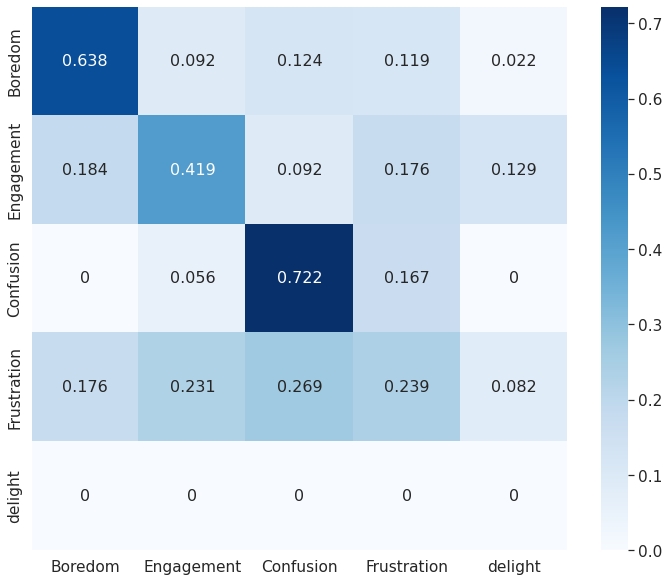

In [ ]:
plot_conf_matrix(labels, y_preds, class_names)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, y_preds, target_names=class_names))

              precision    recall  f1-score   support

     Boredom       0.64      0.25      0.36       478
  Engagement       0.42      0.81      0.55       748
   Confusion       0.76      0.04      0.08       311
 Frustration       0.24      0.31      0.27       406
     delight       0.00      0.00      0.00       235

    accuracy                           0.40      2178
   macro avg       0.41      0.28      0.25      2178
weighted avg       0.44      0.40      0.33      2178



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score: 0.5555631492166266


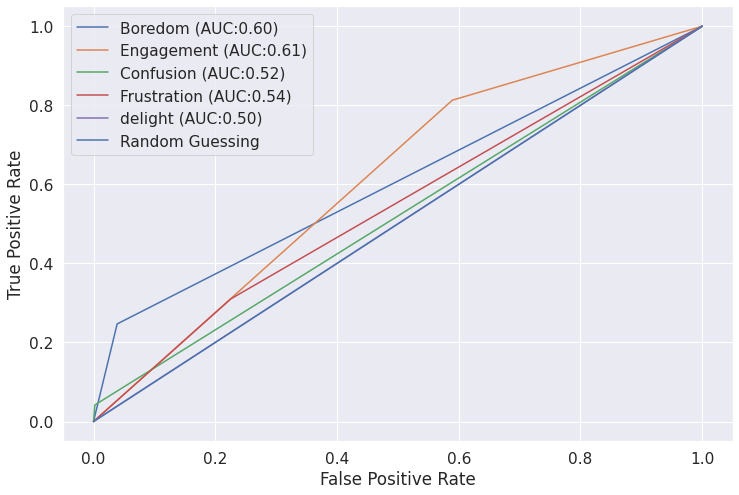

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score




# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(labels, y_preds))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig('ROC_Curve.png')
plt.savefig('ROC_Curve.svg')
plt.show()

In [ ]:
!rm -rf /content/drive/MyDrive/presentation_results_MobileNet
!rm -rf presentation_results_MobileNet
!mkdir presentation_results_MobileNet
!mv *.png presentation_results_MobileNet
!mv *.svg presentation_results_MobileNet
!mv presentation_results_MobileNet drive/MyDrive

#EffientNetB2_expirement

##Load Model

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Daisee/Presentation_Scoring_Models/EfficientNetB2/EfficientNetB2_on_DAiSEE_fc.h5')

In [ ]:
from keras.models import Model

model2= Model(inputs=model.input, outputs=model.layers[-5].output)

In [ ]:
model2.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 640, 640, 3)  0           ['input_11[0][0]']               
                                                                                                  
 normalization_1 (Normalization  (None, 640, 640, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
boredom = Dense(5, name="y1")(model2.output)
engagement = Dense(5, name="y2")(model2.output)
confusion = Dense(5, name="y3")(model2.output)
frustration = Dense(5, name="y4")(model2.output)
delight = Dense(5, name="y5")(model2.output)

model2 = Model(inputs=model2.input,
              outputs=[boredom, engagement, confusion, frustration, delight])

In [ ]:
model2.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 640, 640, 3)  0           ['input_11[0][0]']               
                                                                                                  
 normalization_1 (Normalization  (None, 640, 640, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                           

##Trian Model

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

finetune_at = 116
base_learning_rate = 0.0001
old_epoch = 0
epochs = 10

lr = base_learning_rate

model2.compile(optimizer=RMSprop(learning_rate=lr),
              loss={"y1": CategoricalCrossentropy(from_logits=True),
                    "y2": CategoricalCrossentropy(from_logits=True),
                    "y3": CategoricalCrossentropy(from_logits=True),
                    "y4": CategoricalCrossentropy(from_logits=True),
                    "y5": CategoricalCrossentropy(from_logits=True)},

              metrics={ "y1": "categorical_accuracy",
                        "y2": "categorical_accuracy",
                        "y3": "categorical_accuracy",
                        "y4": "categorical_accuracy",
                        "y5": "categorical_accuracy",
              })
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=1e-2,
                  patience=2, verbose=1),
    ModelCheckpoint(filepath="/content/drive/MyDrive/PresentationScoreModels/EfficientNet_best_model.h5", monitor= 'val_loss', verbose= 1, save_best_only= True, mode = 'auto')
]

total_epochs = epochs 


In [ ]:
for layer in model2.layers[:-8]:
  layer.trainable = False
for layer in model2.layers[-8:]:
  layer.trainable = True

In [ ]:
# for layer in model2.layers[:116]:
#   layer.trainable = False
# for layer in model2.layers[116:]:
#   layer.trainable = True

In [ ]:
jhistory = model2.fit_generator(traingen,
                    steps_per_epoch= STEP_SIZE_TRAIN,
                    epochs= 30, 
                    validation_data= valgen, 
                    initial_epoch=old_epoch,
                    callbacks=callbacks,
                    validation_steps=STEP_SIZE_VALID,
                    verbose=1)

# model2.save('/content/drive/MyDrive/PresentationScoreModels/Daisee.h5')

Epoch 1/30


<ipython-input-169-bff6b5c33b61>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  jhistory = model2.fit_generator(traingen,


2268/2268 [==============================] - ETA: 0s - loss: 7.2067 - y1_loss: 1.4296 - y2_loss: 1.4524 - y3_loss: 1.4487 - y4_loss: 1.4276 - y5_loss: 1.4484 - y1_categorical_accuracy: 0.4094 - y2_categorical_accuracy: 0.3791 - y3_categorical_accuracy: 0.3947 - y4_categorical_accuracy: 0.3909 - y5_categorical_accuracy: 0.3972
Epoch 1: val_loss improved from inf to 5.69437, saving model to /content/drive/MyDrive/PresentationScoreModels/EfficientNet_best_model.h5
2268/2268 [==============================] - 204s 86ms/step - loss: 7.2067 - y1_loss: 1.4296 - y2_loss: 1.4524 - y3_loss: 1.4487 - y4_loss: 1.4276 - y5_loss: 1.4484 - y1_categorical_accuracy: 0.4094 - y2_categorical_accuracy: 0.3791 - y3_categorical_accuracy: 0.3947 - y4_categorical_accuracy: 0.3909 - y5_categorical_accuracy: 0.3972 - val_loss: 5.6944 - val_y1_loss: 1.1302 - val_y2_loss: 1.1708 - val_y3_loss: 1.1452 - val_y4_loss: 1.1098 - val_y5_loss: 1.1383 - val_y1_categorical_accuracy: 0.5993 - val_y2_categorical_accuracy: 0

##Eval

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/PresentationScoreModels/EfficientNet_best_model.h5')

In [ ]:
preds = model.evaluate_generator(valgen)

<ipython-input-171-cc05162371aa>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  preds = model.evaluate_generator(valgen)


In [ ]:
np.array(preds).min()

0.6680440902709961

In [ ]:
pdf = full_dataframe[interval:],
pimgs = full_images[interval:],

In [ ]:
pimgs = np.array(pimgs).squeeze()

In [ ]:
pdf = np.array(pdf).squeeze()

In [ ]:
len(pdf),len(pimgs)

(2178, 2178)

In [ ]:
npdf = []
for pf in pdf:
  npdf.append(pf[1])

In [ ]:
len(npdf)

2178

In [ ]:
preds= []
pimages = []
for img in pimgs:
  img = cv2.resize(img,(640,640))
  # pred = np.argmax(model.predict(img[None]))

  pimages.append(img)

In [ ]:
model_result = model.evaluate(valgen)

2178/2178 [==============================] - 48s 22ms/step - loss: 4.4150 - y1_loss: 0.8716 - y2_loss: 0.8818 - y3_loss: 0.8905 - y4_loss: 0.8811 - y5_loss: 0.8899 - y1_categorical_accuracy: 0.6717 - y2_categorical_accuracy: 0.6680 - y3_categorical_accuracy: 0.6726 - y4_categorical_accuracy: 0.6758 - y5_categorical_accuracy: 0.6699


In [ ]:
class_names = ['Boredom', 'Engagement', 'Confusion', 'Frustration','delight']


def print_accuracy(result):
    """Print accuracy for all the classes."""
    print("Accuracy: ")
    for i, acc in enumerate(result[6:]):
        print(f"{class_names[i]}: {acc*100}")
    print(f"Model_accuracy: {np.array(result[6:]).mean()*100}")


In [ ]:
print_accuracy(model_result)

Accuracy: 
Boredom: 67.17171669006348
Engagement: 66.80440902709961
Confusion: 67.26354360580444
Frustration: 67.58493781089783
delight: 66.98806285858154
Model_accuracy: 67.16253399848938


##Final Model

In [ ]:
from keras.models import Model

model2= Model(inputs=model.input, outputs=model.layers[-6].output)

In [ ]:
model2.predict(pimages[100][None])

1/1 [==============================] - 2s 2s/step


array([[1.3064272 , 0.        , 0.        , 2.4380774 , 1.5487719 ,
        2.4180472 , 0.3431485 , 0.8984225 , 1.7983239 , 2.8788142 ,
        0.        , 0.        , 0.        , 1.5097296 , 0.06574894,
        0.        , 1.7203002 , 0.        , 0.        , 0.47315907,
        0.        , 1.6815476 , 0.11351895, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.11038913, 0.        , 0.2591675 , 0.        , 0.        ,
        0.        , 1.0948129 , 0.        , 0.20671359, 0.13457434,
        0.27267668, 3.321215  , 0.86363345, 0.10865328, 1.150554  ,
        0.        , 0.        , 0.21985202, 0.29538438, 0.        ,
        0.        , 0.6861338 , 0.47391042, 0.40092582, 0.2975601 ,
        0.        , 0.        , 1.1606607 , 0.16431096, 0.        ,
        0.        , 1.1747807 , 0.        , 0.        ]], dtype=float32)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy

In [ ]:
base_model = model2

for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=5 , activation='softmax' )(x)

# creating our model.
model3 = Model(base_model.input, x)

In [ ]:
model3.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )

## having early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="/content/drive/MyDrive/PresentationScoreModels/EfficientNet_best_model_final.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]
hist = model3.fit_generator(traingen, 
                           steps_per_epoch= STEP_SIZE_TRAIN,
                           epochs= 30, 
                           validation_data= valgen, 
                           validation_steps= STEP_SIZE_VALID, 
                           callbacks=call_back,
                           verbose=1)

Epoch 1/30


<ipython-input-188-6beb6d402206>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model3.fit_generator(traingen,


2268/2268 [==============================] - ETA: 0s - loss: 1.0507 - accuracy: 0.5948
Epoch 1: val_accuracy improved from -inf to 0.66912, saving model to /content/drive/MyDrive/PresentationScoreModels/EfficientNet_best_model_final.h5
2268/2268 [==============================] - 207s 88ms/step - loss: 1.0507 - accuracy: 0.5948 - val_loss: 0.8179 - val_accuracy: 0.6691
Epoch 2/30
2268/2268 [==============================] - ETA: 0s - loss: 0.9199 - accuracy: 0.6452
Epoch 2: val_accuracy did not improve from 0.66912
2268/2268 [==============================] - 197s 87ms/step - loss: 0.9199 - accuracy: 0.6452 - val_loss: 1.0265 - val_accuracy: 0.5956
Epoch 3/30
2268/2268 [==============================] - ETA: 0s - loss: 0.9056 - accuracy: 0.6564
Epoch 3: val_accuracy did not improve from 0.66912
2268/2268 [==============================] - 196s 86ms/step - loss: 0.9056 - accuracy: 0.6564 - val_loss: 0.8551 - val_accuracy: 0.6434
Epoch 4/30
2268/2268 [==============================] - ET

In [ ]:
!mv best_model2.h5 /content/drive/MyDrive

mv: cannot stat 'best_model2.h5': No such file or directory


In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/PresentationScoreModels/EfficientNet_best_model_final.h5')

##Results

In [ ]:
preds = model.predict(
    valgen ,
    batch_size=8,
    verbose="auto",
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

2178/2178 [==============================] - 43s 19ms/step


In [ ]:
int_mapping = {x: i for i,x in enumerate(class_names)}
labels = []
for label in npdf:
  label = integer_mapping[label]
  labels.append(label)


In [ ]:
labs = np.repeat(labels,8)

In [ ]:
len(labs)

17424

In [ ]:
# preds = []
# for img in pimages[:]:
#   img = img/255.
#   pred = np.argmax((model.predict(img[None]))[0])
#   print(pred)
#   preds.append(pred)
preds = model.predict(valgen, steps=valgen.n, workers=100)

2178/2178 [==============================] - 40s 18ms/step


In [ ]:
y_preds = []
for pred in preds:
  pred = np.argmax(pred)
  y_preds.append(pred)

In [ ]:
y_preds[50]

4

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
from sklearn.metrics import roc_curve, auc
import pandas as pd 

def plot_conf_matrix(true, pred, classes):
    cf = confusion_matrix(true, pred)
    plt.figure(figsize=(12,10))
    sns.set(font_scale=1.4)
    sns.heatmap(np.round(cf / cf.sum(axis=0), 3).T, annot=True, annot_kws={"size": 16},fmt='g',
                cmap='Blues', xticklabels = classes ,yticklabels = classes)
    plt.savefig('confusion_matrix.png')
    plt.savefig('confusion_matrix.svg')

    plt.show()


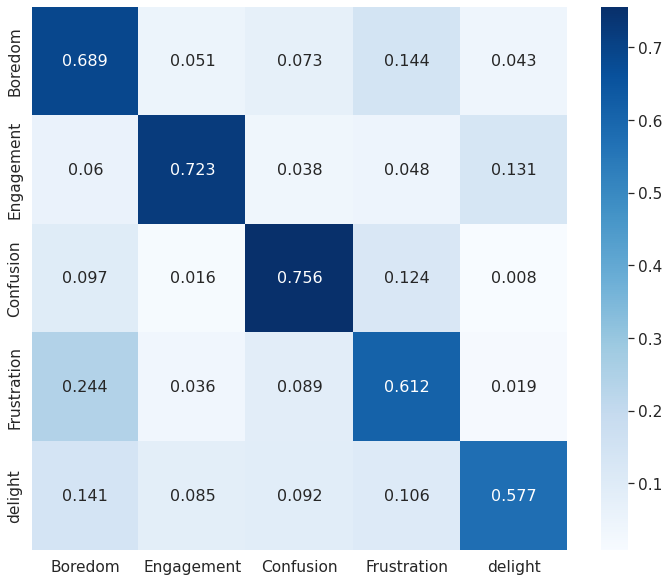

In [ ]:
plot_conf_matrix(labels, y_preds, class_names)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, y_preds, target_names=class_names))

              precision    recall  f1-score   support

     Boredom       0.69      0.57      0.62       478
  Engagement       0.72      0.93      0.81       748
   Confusion       0.76      0.63      0.69       311
 Frustration       0.61      0.63      0.62       406
     delight       0.58      0.35      0.44       235

    accuracy                           0.69      2178
   macro avg       0.67      0.62      0.64      2178
weighted avg       0.68      0.69      0.68      2178



ROC AUC score: 0.7694323170944241


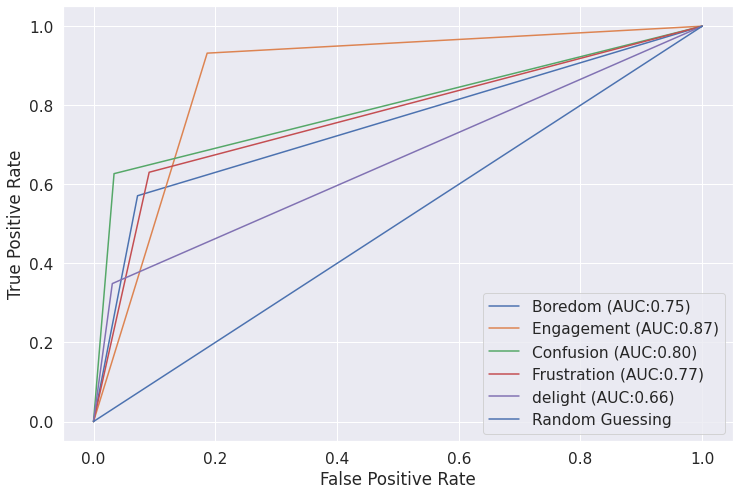

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score




# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(labels, y_preds))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig('ROC_Curve.png')
plt.savefig('ROC_Curve.svg')
plt.show()

In [ ]:
!mkdir presentation_results_EfficientNet
!mv *.png presentation_results_EfficientNet
!mv *.svg presentation_results_EfficientNet
!mv presentation_results_EfficientNet drive/MyDrive